# Monte Carlo 13C MFA MOMA and ROOM
By Tyler W. H. Backman and Christina Schenk

This notebook demonstrates the prediction of genome knockouts by performing linear MOMA[1] on each of a distribution of samples.

#### References:
[1] Proc Natl Acad Sci U S A. 2002 Nov 12;99(23):15112-7. Epub 2002 Nov 1.
Analysis of optimality in natural and perturbed metabolic networks.
Segrè D1, Vitkup D, Church GM.

#### some notes on distance metrics to consider
https://stats.stackexchange.com/questions/4044/measuring-the-distance-between-two-multivariate-distributions

In [1]:
from os import path
from kl import KLdivergence
import numpy as np
import pandas as pd
import bayflux
import cobra

cobra/core/dictlist.py:215 SyntaxWarning: "is" with a literal. Did you mean "=="?


### Specify input files

In [2]:
# setup options
modelFile = path.join('data', 'ecoli_genome_scale.xml')
dataDir = 'outputdata'
samplesToUse = 100

sampleFiles = {
    'wt5h': path.join(dataDir, 'bayflux_ecoli_genomescale001.npy'),
    'pgi16h': path.join(dataDir, 'toyapgi16h001.npy'),
    'pyk5h': path.join(dataDir, 'toyapyk5h001.npy'),
}

constraintDataDir = 'data'
constraintFiles = {
    'wt5h': path.join(constraintDataDir, 'ecoli_genome_scaleFluxBounds_wt5h.csv'),
    'pgi16h': path.join(constraintDataDir, 'ecoli_genome_scaleFluxBounds_pgi16h.csv'),
    'pyk5h': path.join(constraintDataDir, 'ecoli_genome_scaleFluxBounds_pyk5h.csv'),
}

In [3]:
# Read the model file
cobramodel = cobra.io.read_sbml_model(modelFile)

#Transfer cobramodel to bayflux model
model = bayflux.ReactionNetwork(cobramodel)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Define function for keeping only representative samples

In [4]:
def subSample(inputFile, chains, warmupLength, sampleSize, model, netfluxOnly=True):
    # Reads in a set of BayFlux samples from a .npy inputFile, with a given number of chains
    # and warmup samples. Will keep a representative set of integer sampleSize samples occuring after
    # the first 'warmupLength' samples on each chain, and discard the rest. If netfluxOnly=True,
    # only net flux values are returned.
    
    # read in data
    data = np.load(inputFile, mmap_mode='r')
    
    # confirm we have enough valid samples
    assert data.shape[0] >= (sampleSize + (chains * warmupLength)), 'not enough samples'
    
    # Create a list of integers selecting 100k points to remove from the above samples
    # Discard the first 1/4 from each chain
    samplesPerChain = int(data.shape[0] / chains)

    # step size to keep
    # here we use a floating point step size, which gets converted to an integer
    # before indexing, allowing for unevenly spaced increments- thereby letting the
    # subset scale to the desired size
    stepSize = (samplesPerChain - warmupLength) / (sampleSize / chains)
    
    # store inidces samples to be kept in a list
    samplesToKeep = []

    # interate over chains and get indices of samples to keep
    for chain in range(0, chains):
              
        # create series of sample numbers to keep for this chain
        subsetToKeepThisChain = [int(x) for x in np.arange(warmupLength, samplesPerChain, stepSize)]
        
        # assert that each index is unique
        assert len(set(subsetToKeepThisChain)) == len(subsetToKeepThisChain), 'sample indices not unique- not enough samples?'
        
        # adjust sample position based on which chain we're on
        subsetToKeep = [i + (samplesPerChain * chain) for i in subsetToKeepThisChain]
        
        # append indices to list of samples to be kept
        samplesToKeep = samplesToKeep + subsetToKeep
    
    # extract the subset of samples to keep
    dataSubset = data[samplesToKeep]
    
    # put the samples in a Pandas DF
    dataSubset = pd.DataFrame(dataSubset, columns=[v.name for v in model.variables])
    
    if netfluxOnly:
        # substract both directions to get netFlux
        dataSubset = np.subtract(dataSubset.iloc[0::1,0::2], dataSubset.iloc[0::1,1::2])
        
    # cofirm we did the math right and we got the right number of samples to return    
    assert dataSubset.shape[0] == sampleSize, 'error- trying to return the wrong number of samples!'
    
    return dataSubset

### Import samples

In [5]:
samples_wt5h = subSample(sampleFiles['wt5h'], 4, 10000, samplesToUse, model)
samples_pyk5h = subSample(sampleFiles['pyk5h'], 4, 10000, samplesToUse, model)
samples_pgi16h = subSample(sampleFiles['pgi16h'], 4, 10000, samplesToUse, model)

/tmp/ipykernel_2780149/4104190541.py:49 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [6]:
samples_wt5h.shape

(100, 719)

### Compute multivariate Kullback–Leibler divergence (distance) between wild type and knockouts

In [7]:
distances = {}

In [8]:
distances['pyk5h_wt5h'] = KLdivergence(samples_pyk5h, samples_wt5h)

In [9]:
distances['pgi16h_wt5h'] = KLdivergence(samples_pgi16h, samples_wt5h)

In [10]:
distances

{'pyk5h_wt5h': 107.54974452189778, 'pgi16h_wt5h': 1218.075270258619}

### Predict fluxes from wild type using 13C sampling based MOMA and ROOM

In [11]:
def momaFluxes(model, fluxSample):
    solution = cobra.core.Solution(0.0, 'optimal', fluxSample)
    momaFluxes = cobra.flux_analysis.moma(model, solution, linear=True)
    return momaFluxes.fluxes

def roomFluxes(model, fluxSample):
    solution = cobra.core.Solution(0.0, 'optimal', fluxSample)
    roomFluxes = cobra.flux_analysis.room(model, solution, linear=True)#delta=0.03, epsilon=0.001 by default
    return roomFluxes.fluxes

In [12]:
pykmodel = cobramodel.copy()
pykreactionnet = bayflux.ReactionNetwork(pykmodel)

# Import and apply exchange fluxes from file
pykreactionnet.readFluxConstraints(constraintFiles['pyk5h'])

In [13]:
%%time
momaPykPrediction = samples_wt5h.apply(lambda x: momaFluxes(pykreactionnet, x), axis=1)

CPU times: user 2min 46s, sys: 2.07 s, total: 2min 48s
Wall time: 2min 48s


In [14]:
%%time
roomPykPrediction = samples_wt5h.apply(lambda x: roomFluxes(pykreactionnet, x), axis=1)

cobra/util/solver.py:434 UserWarning: solver status is 'infeasible'


CPU times: user 4min, sys: 1.64 s, total: 4min 2s
Wall time: 4min 2s


In [15]:
distances['pyk5h_moma'] = KLdivergence(samples_pyk5h, momaPykPrediction)
distances['pyk5h_room'] = KLdivergence(samples_pyk5h, roomPykPrediction)

In [16]:
pgimodel = cobramodel.copy()
pgireactionnet = bayflux.ReactionNetwork(pgimodel)

# Import and apply exchange fluxes from file
pgireactionnet.readFluxConstraints(constraintFiles['pgi16h'])

In [17]:
%%time
momaPgiPrediction = samples_wt5h.apply(lambda x: momaFluxes(pgireactionnet, x), axis=1)

CPU times: user 2min 49s, sys: 1.51 s, total: 2min 50s
Wall time: 2min 50s


In [18]:
%%time
roomPgiPrediction = samples_wt5h.apply(lambda x: roomFluxes(pgireactionnet, x), axis=1)

CPU times: user 3min 58s, sys: 1.69 s, total: 4min
Wall time: 4min


In [19]:
distances['pgi16h_moma'] = KLdivergence(samples_pyk5h, momaPgiPrediction)
distances['pgi16h_room'] = KLdivergence(samples_pyk5h, roomPgiPrediction)

In [20]:
distances

{'pyk5h_wt5h': 107.54974452189778,
 'pgi16h_wt5h': 1218.075270258619,
 'pyk5h_moma': 106.43733024727872,
 'pyk5h_room': 645.1752991638111,
 'pgi16h_moma': 556.0223456838348,
 'pgi16h_room': 817.2099256989665}

### Predict fluxes using FBA based MOMA and ROOM 

In [21]:
# get wt5h FBA solution
model.readFluxConstraints(constraintFiles['wt5h'])

In [22]:
# make sure growth rate is unconstrained for FBA to work properly
model.reactions.BIOMASS_Ec_iAF1260_core_59p81M.lower_bound = 0.00
model.reactions.BIOMASS_Ec_iAF1260_core_59p81M.upper_bound = 10000.00

In [23]:
FBAwt5hfluxes = model.optimize().fluxes
solution = cobra.core.Solution(0.0, 'optimal', FBAwt5hfluxes)

In [24]:
# compute FBA based moma predictions
fbamoma_pyk5h = cobra.flux_analysis.moma(pykreactionnet, solution, linear=True)
fbamoma_pgi16h = cobra.flux_analysis.moma(pgireactionnet, solution, linear=True)

# compute FBA based room predictions
fbaroom_pyk5h = cobra.flux_analysis.room(pykreactionnet, solution, linear=True)
fbaroom_pgi16h = cobra.flux_analysis.room(pgireactionnet, solution, linear=True)

In [25]:
# apply 'dirac delta' to sample the point solution samplesToUse times
pyk5h_moma_diracsample = np.tile(fbamoma_pyk5h.fluxes, (samplesToUse,1))
pgi16h_moma_diracsample = np.tile(fbamoma_pgi16h.fluxes, (samplesToUse,1))

# apply 'dirac delta' to sample the point solution samplesToUse times
pyk5h_room_diracsample = np.tile(fbaroom_pyk5h.fluxes, (samplesToUse,1))
pgi16h_room_diracsample = np.tile(fbaroom_pgi16h.fluxes, (samplesToUse,1))

In [26]:
# compute distances
distances['pyk5h_FBAmoma'] = KLdivergence(samples_pyk5h, pyk5h_moma_diracsample)
distances['pgi16h_FBAmoma'] = KLdivergence(samples_pyk5h, pgi16h_moma_diracsample)
distances['pyk5h_FBAroom'] = KLdivergence(samples_pyk5h, pyk5h_room_diracsample)
distances['pgi16h_FBAroom'] = KLdivergence(samples_pyk5h, pgi16h_room_diracsample)

In [27]:
distances

{'pyk5h_wt5h': 107.54974452189778,
 'pgi16h_wt5h': 1218.075270258619,
 'pyk5h_moma': 106.43733024727872,
 'pyk5h_room': 645.1752991638111,
 'pgi16h_moma': 556.0223456838348,
 'pgi16h_room': 817.2099256989665,
 'pyk5h_FBAmoma': 667.441796588194,
 'pgi16h_FBAmoma': 821.481600558068,
 'pyk5h_FBAroom': 673.6571263501578,
 'pgi16h_FBAroom': 833.9375104538583}

# Figure for paper

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

12PPDRtex


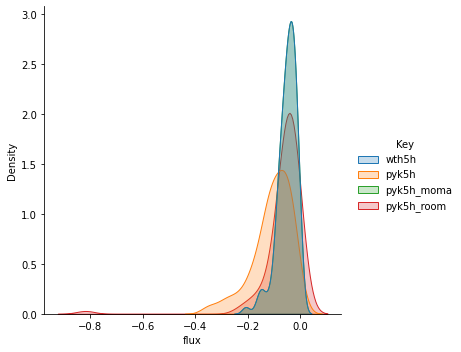

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


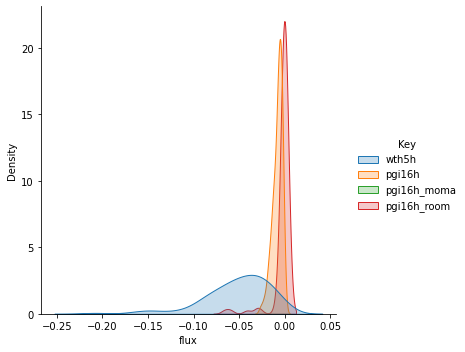

12PPDRtpp


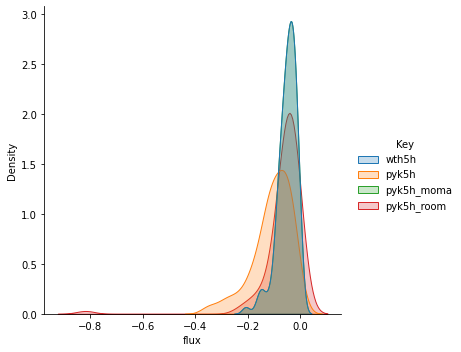

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


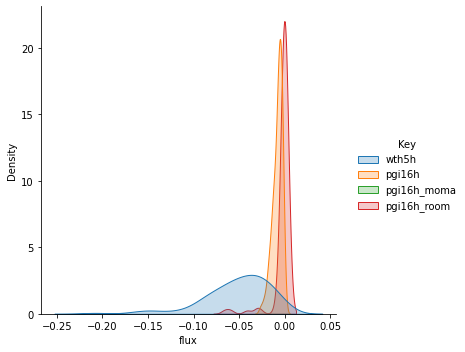

3HAD100


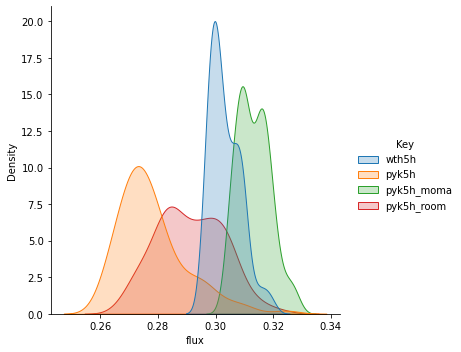

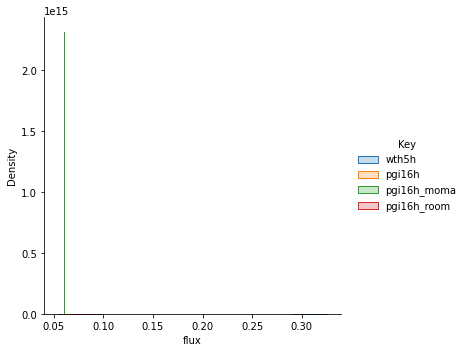

3HAD120


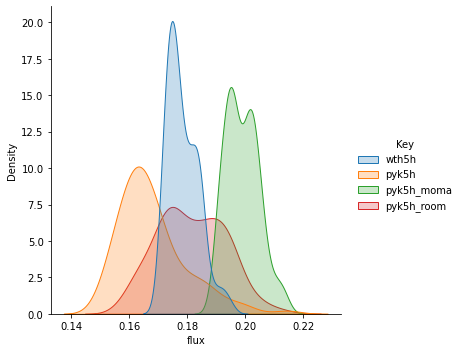

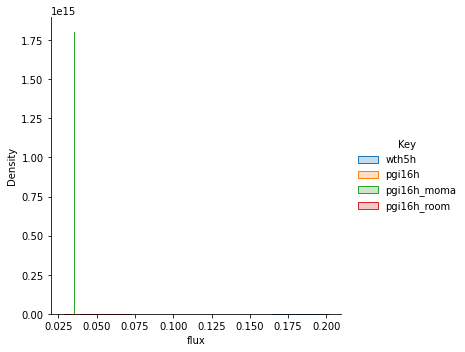

3HAD121


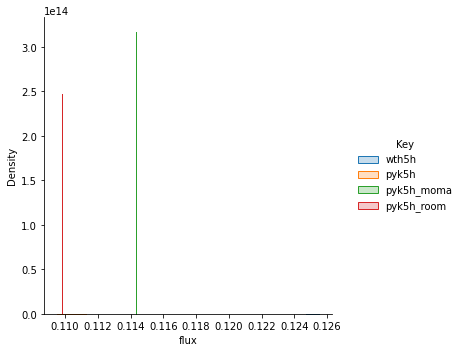

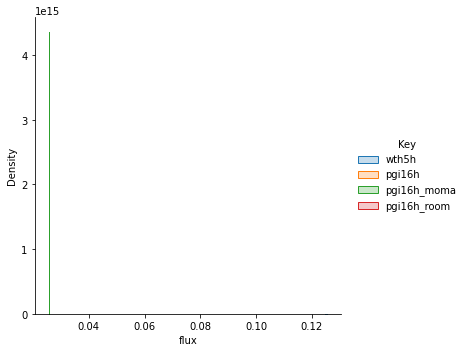

3HAD140


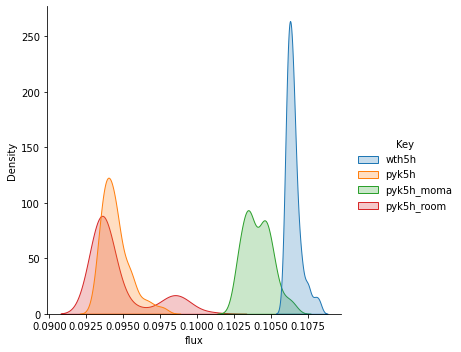

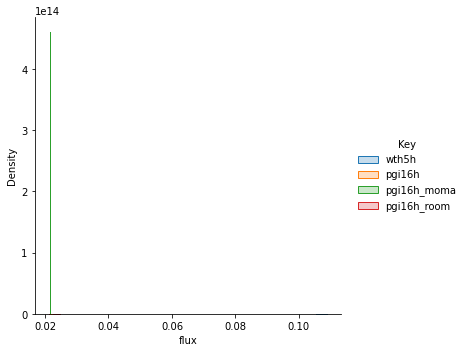

3HAD141


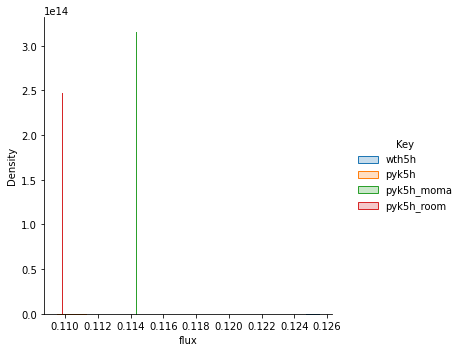

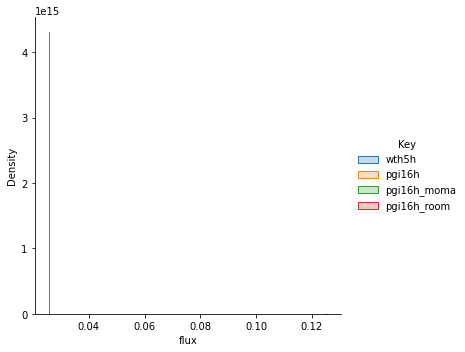

3HAD160


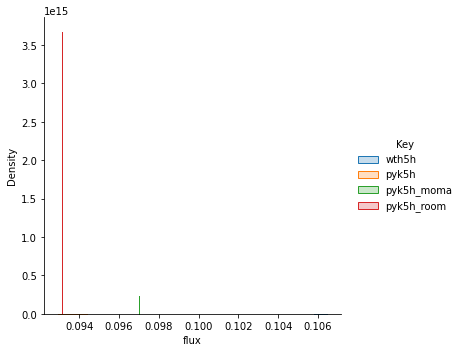

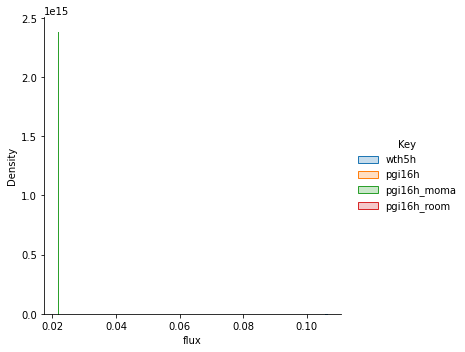

3HAD161


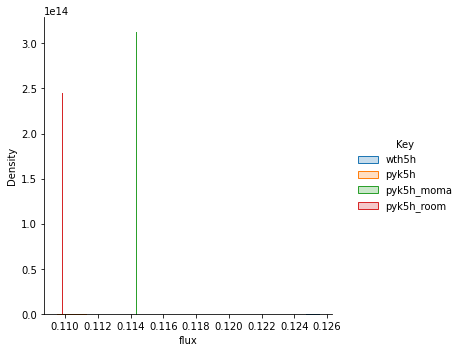

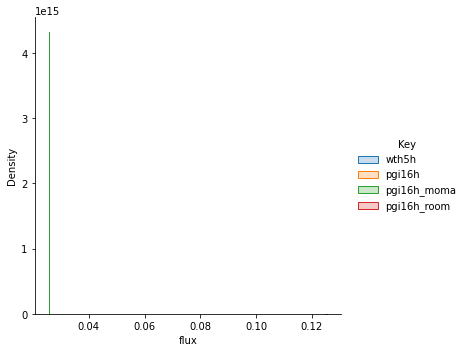

3HAD40


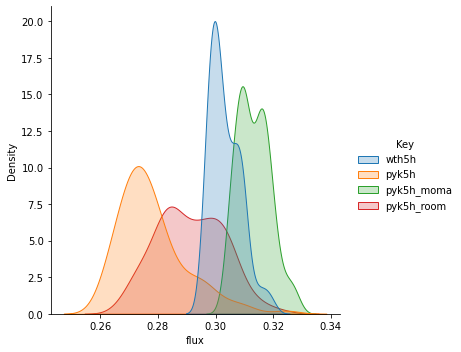

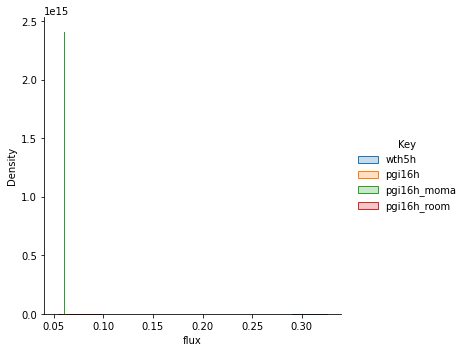

3HAD60


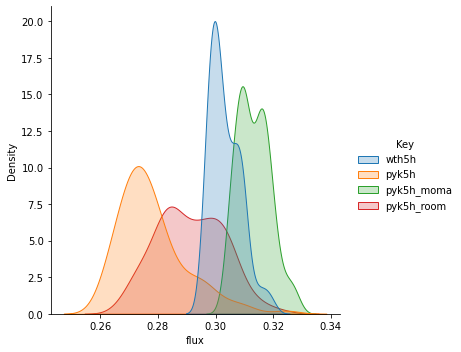

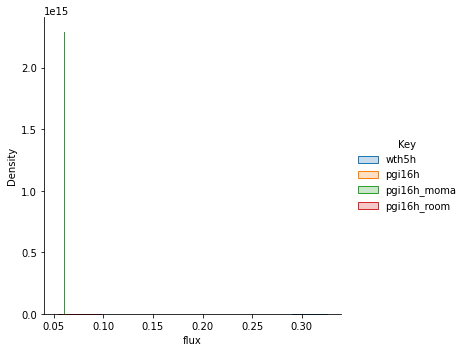

3HAD80


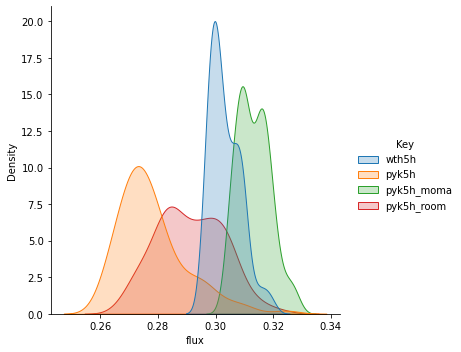

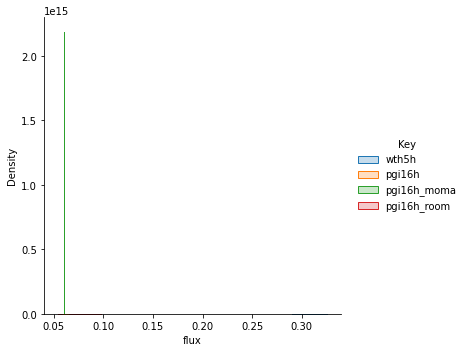

3OAR100


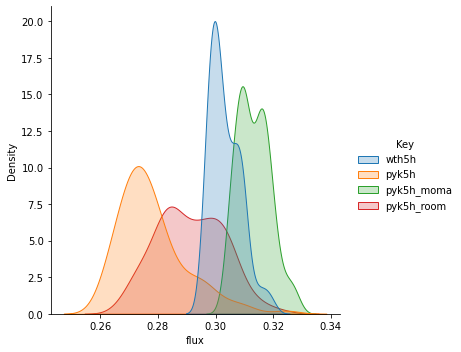

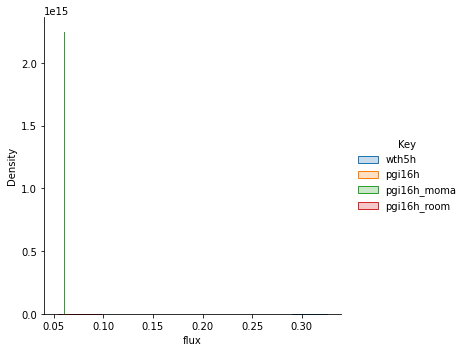

3OAR120


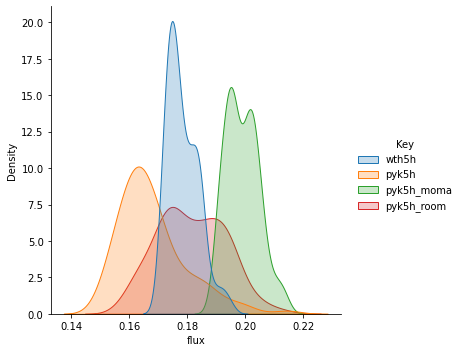

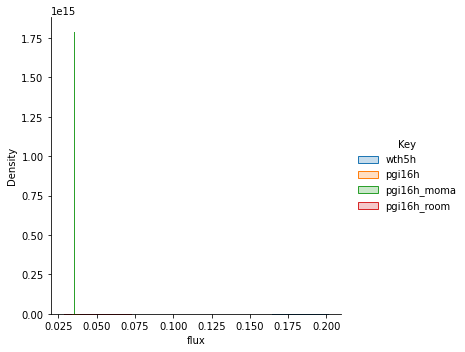

3OAR121


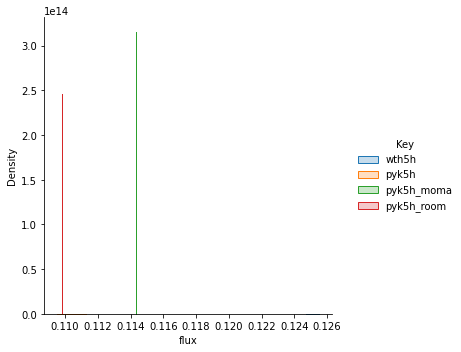

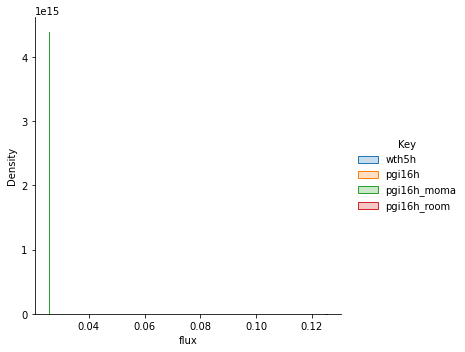

3OAR140


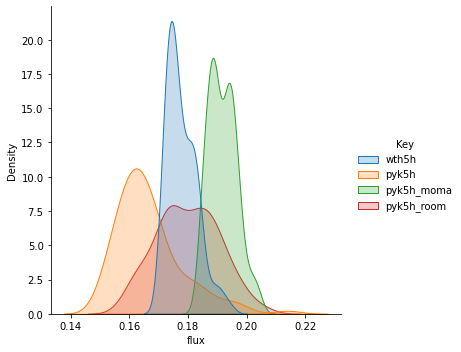

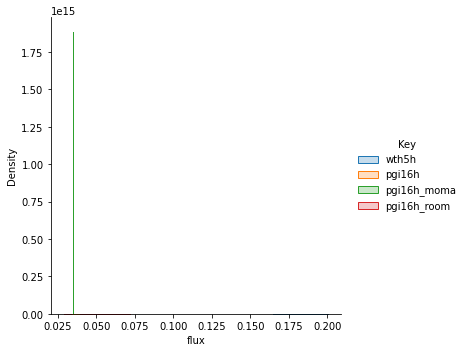

3OAR141


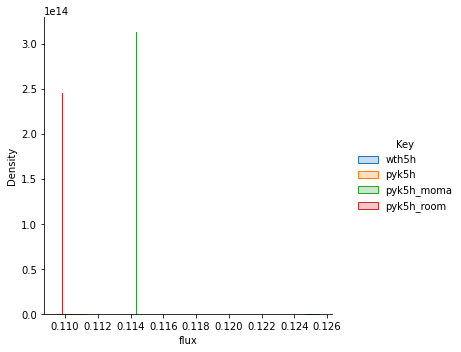

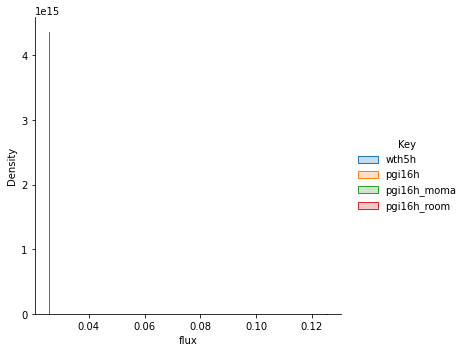

3OAR160


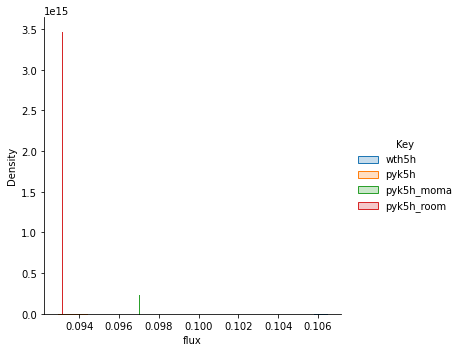

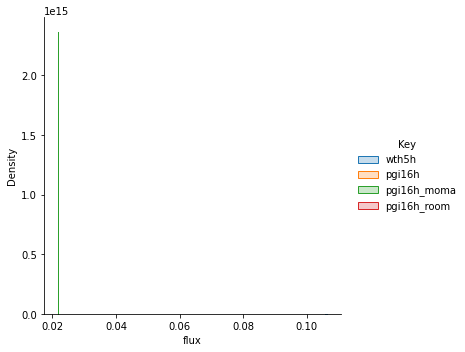

3OAR161


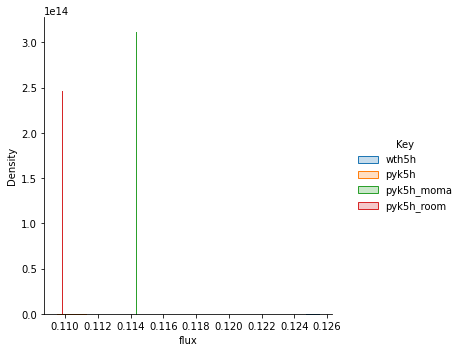

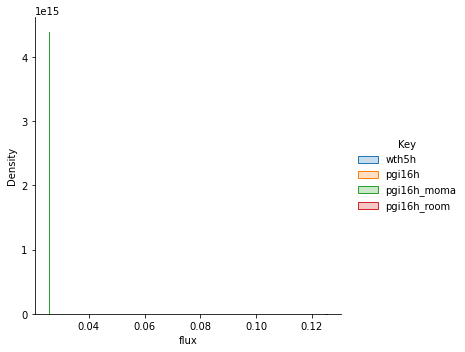

3OAR40


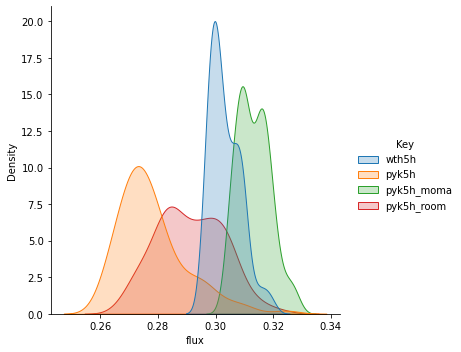

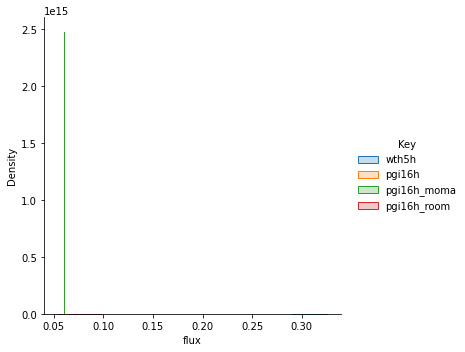

3OAR60


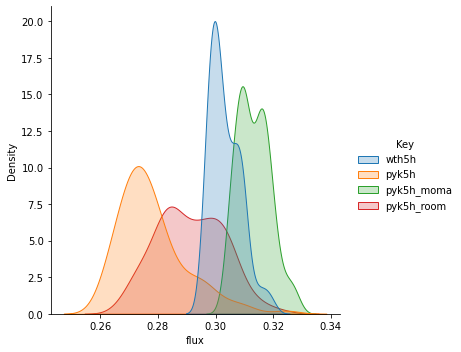

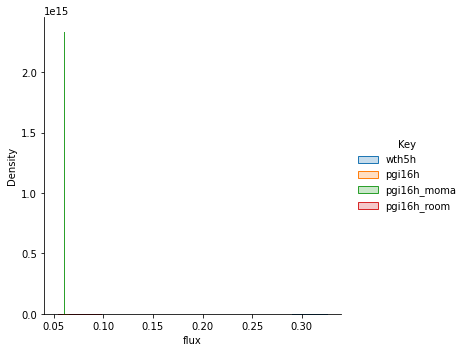

3OAR80


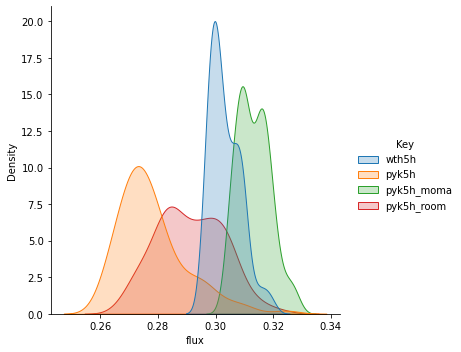

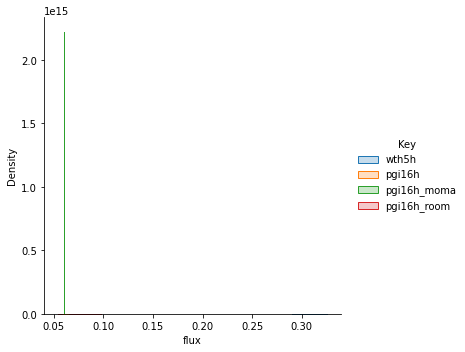

3OAS100


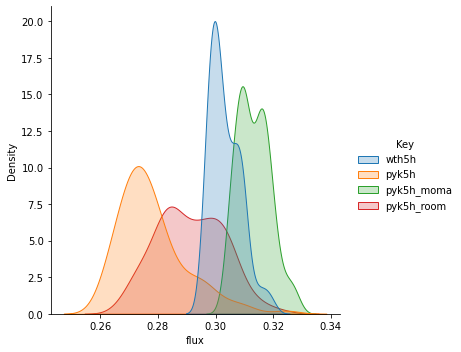

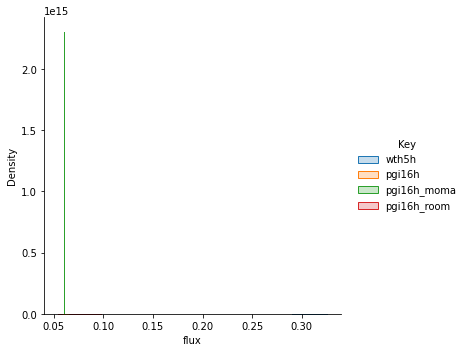

3OAS120


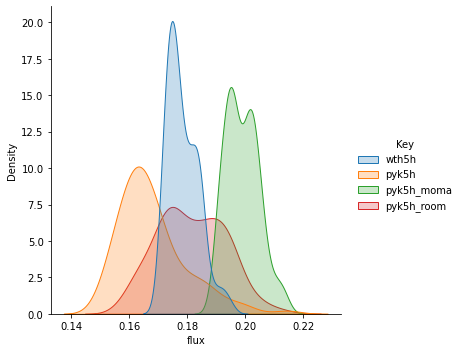

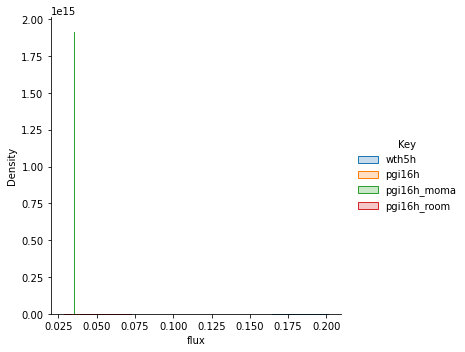

3OAS121


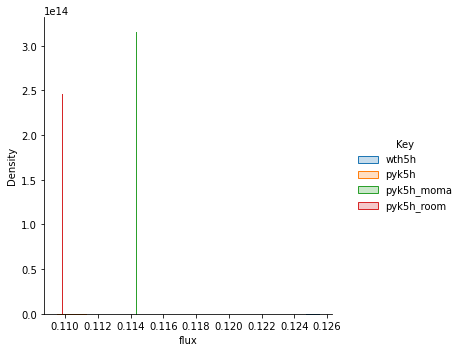

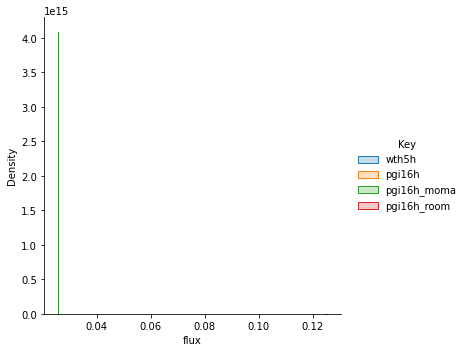

3OAS140


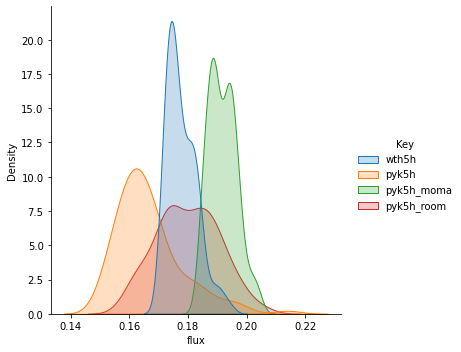

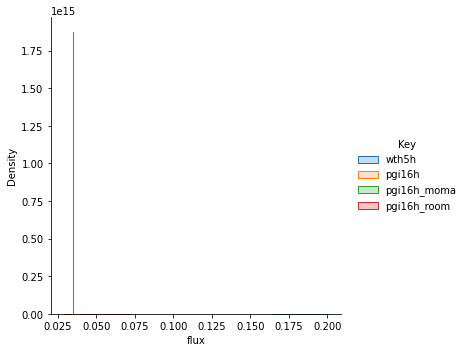

3OAS141


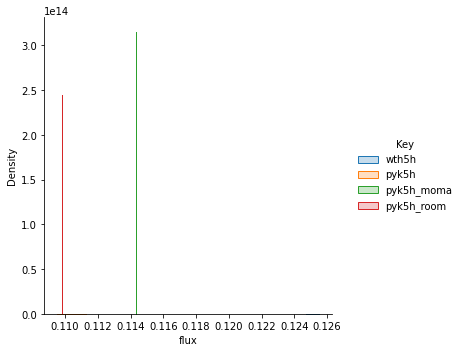

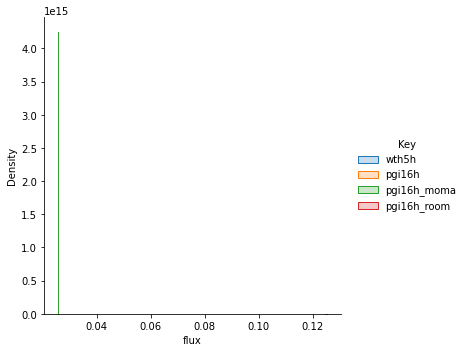

3OAS160


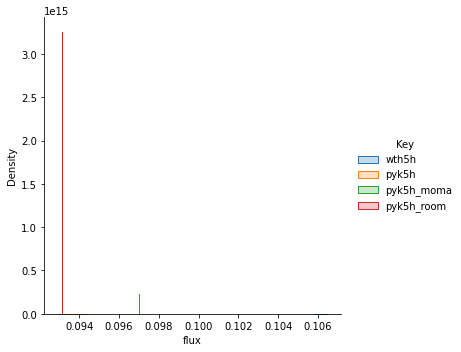

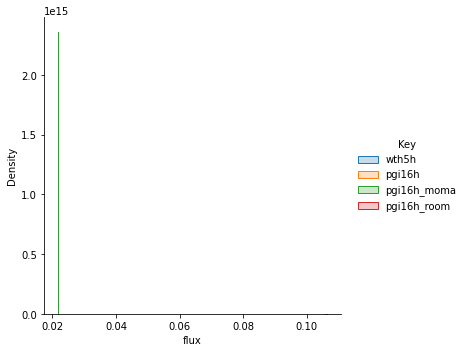

3OAS161


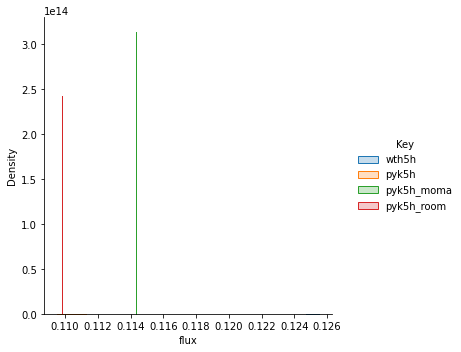

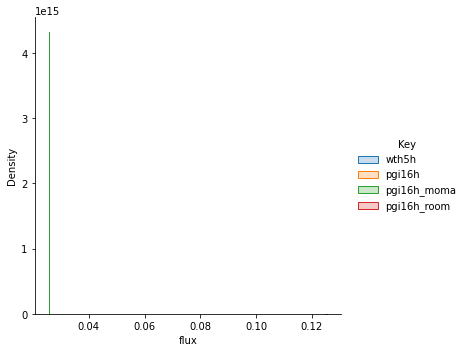

3OAS60


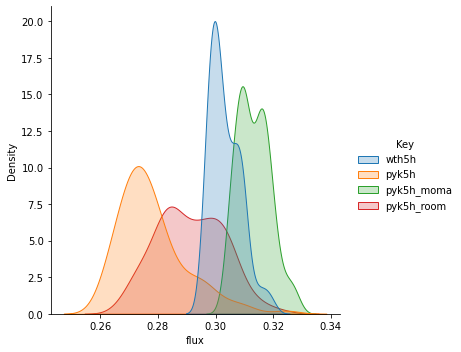

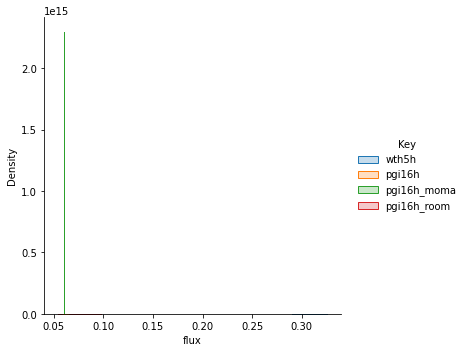

3OAS80


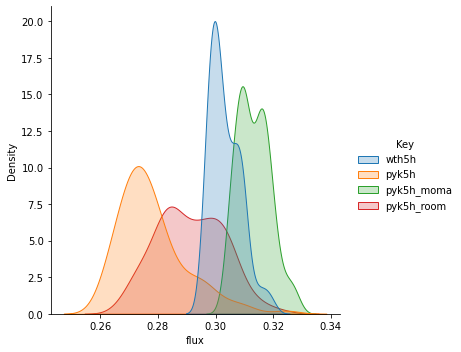

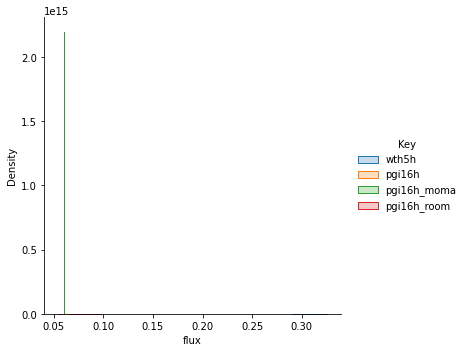

A5PISO


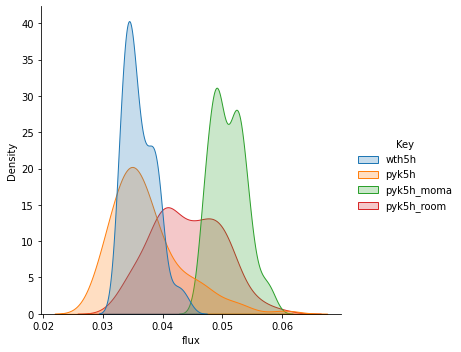

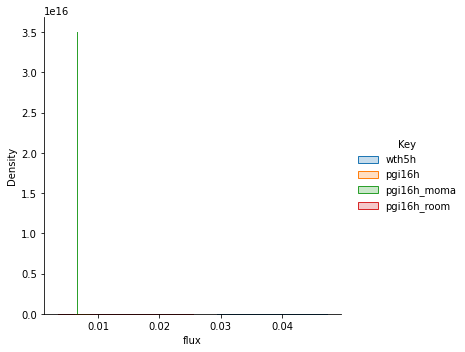

AACTOOR


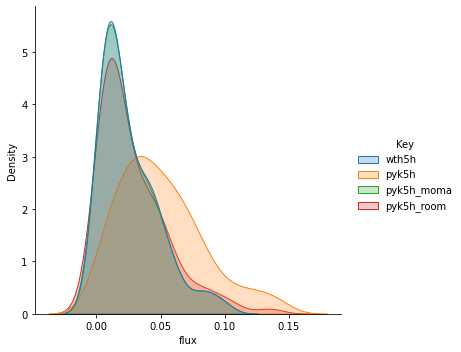

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


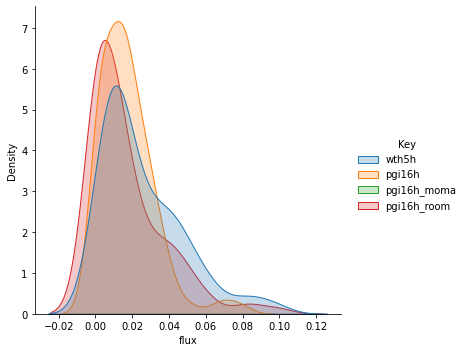

ABTA


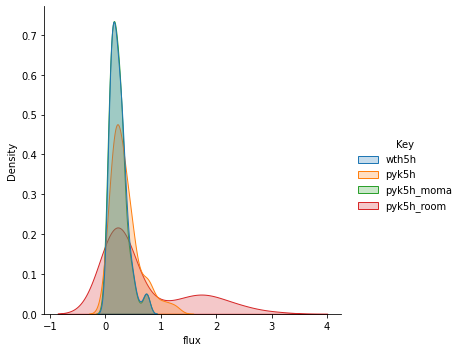

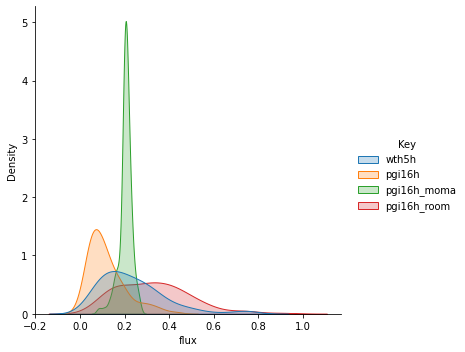

ABUTD


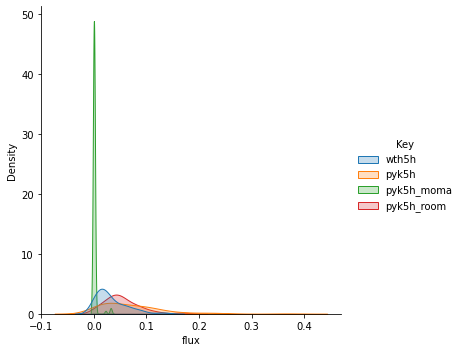

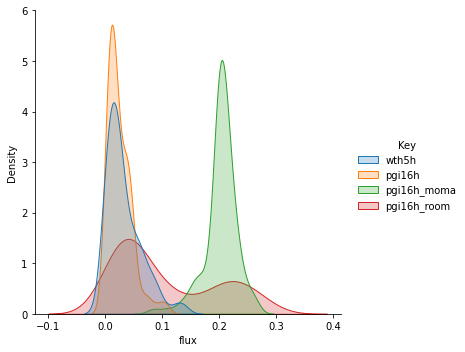

ABUTt2pp


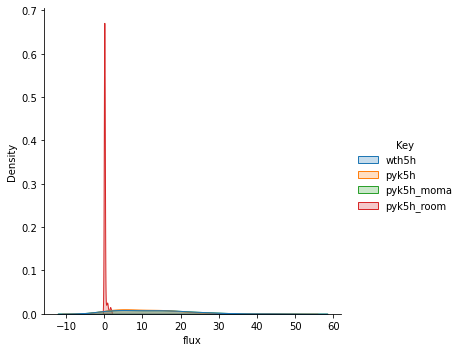

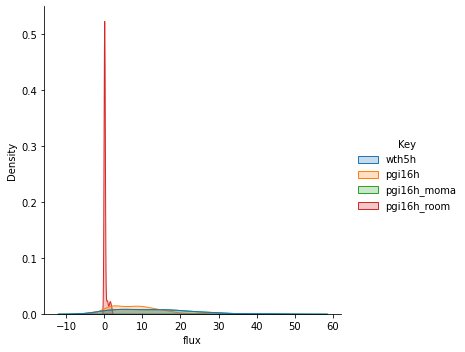

ABUTtex


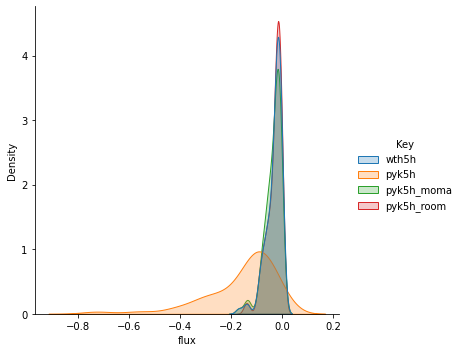

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


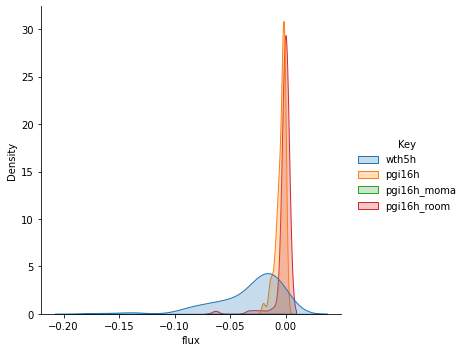

ACALD


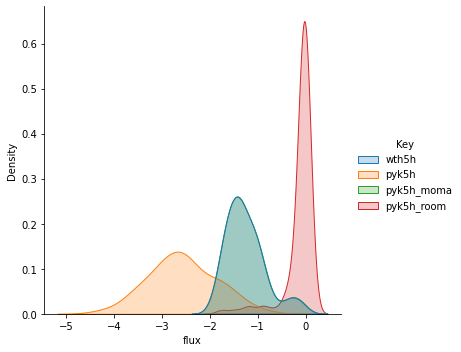

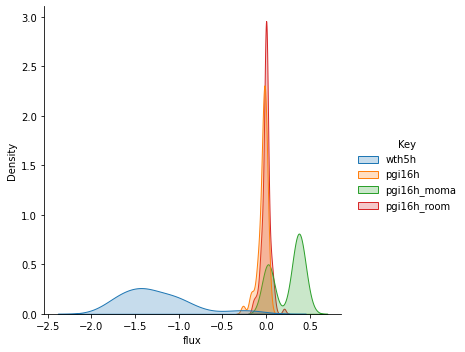

ACCOAC


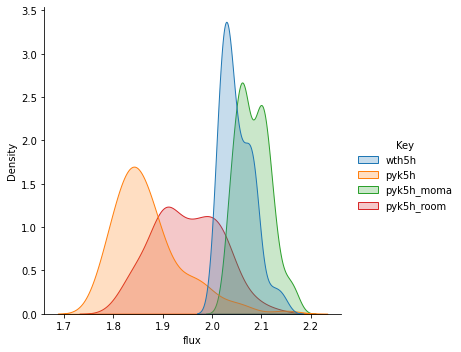

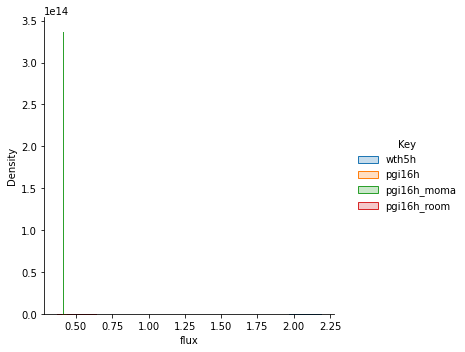

ACGK


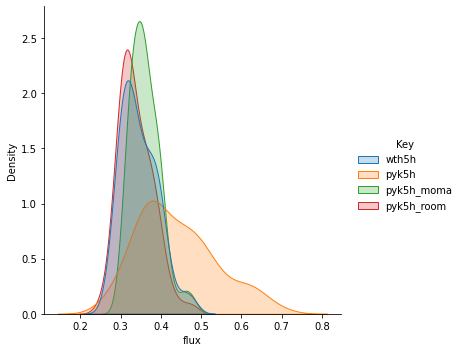

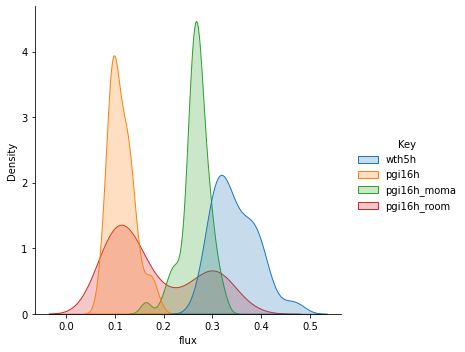

ACGS


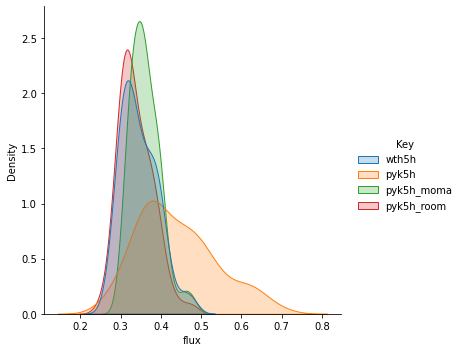

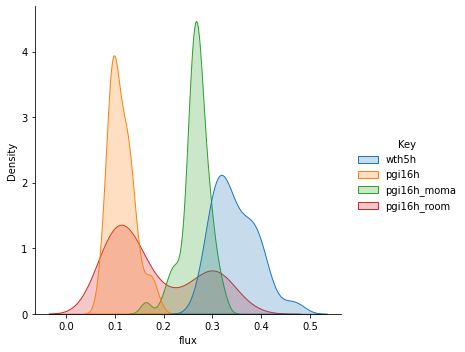

ACHBS


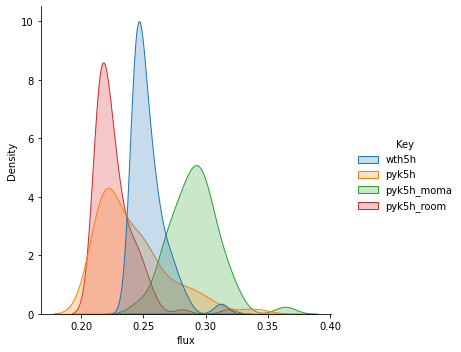

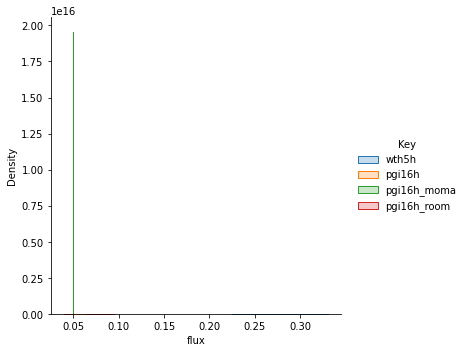

ACKr


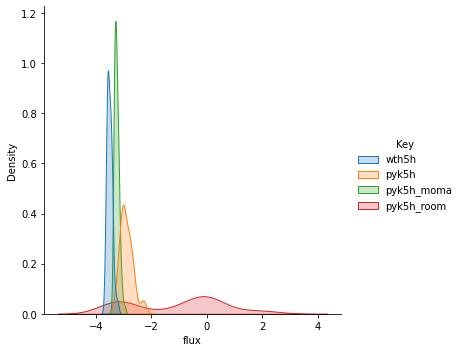

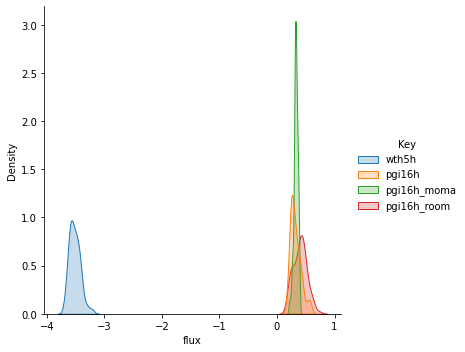

ACLS


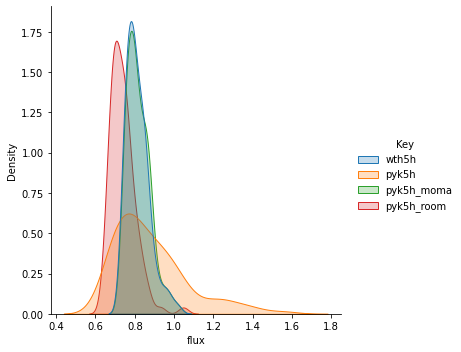

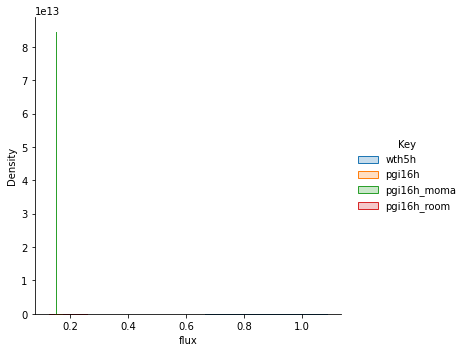

ACOATA


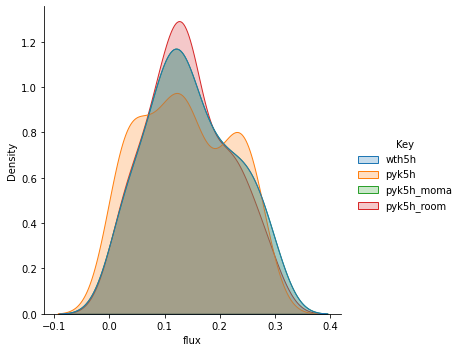

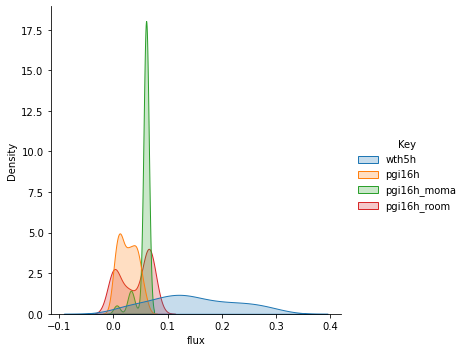

ACODA


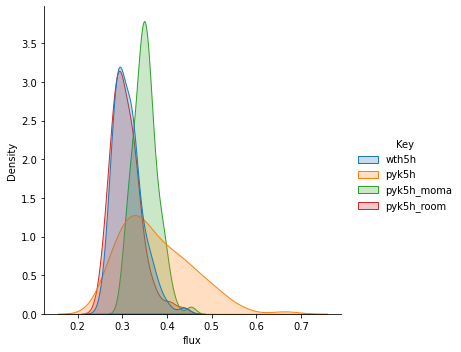

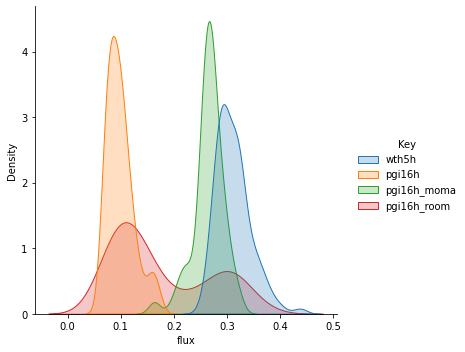

ACONTa


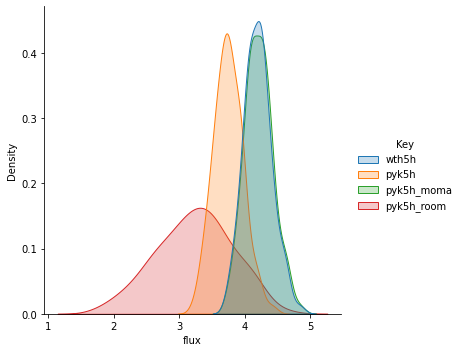

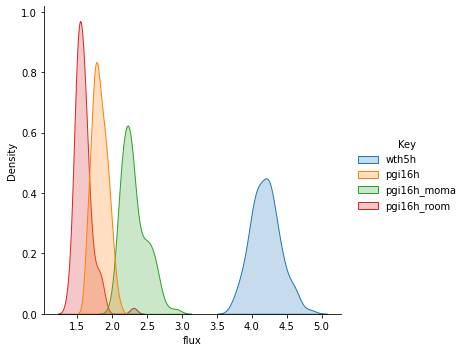

ACONTb


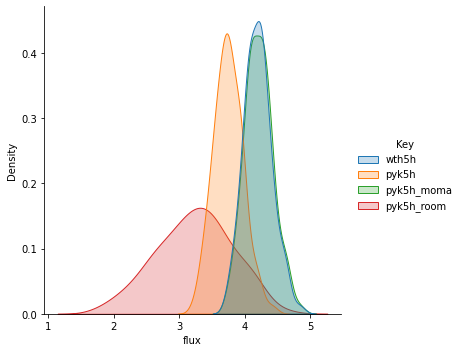

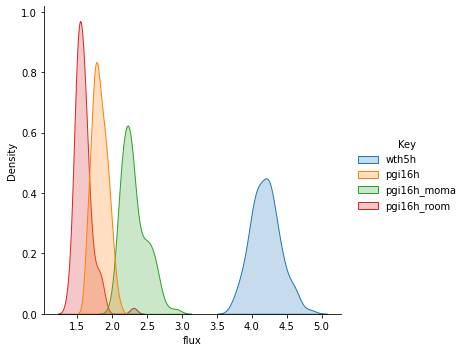

ACOTA


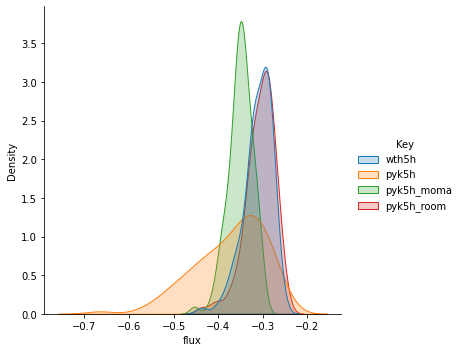

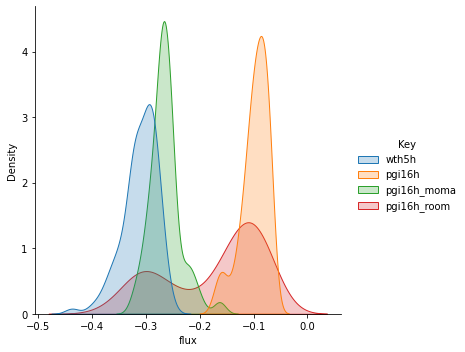

ACSERtex


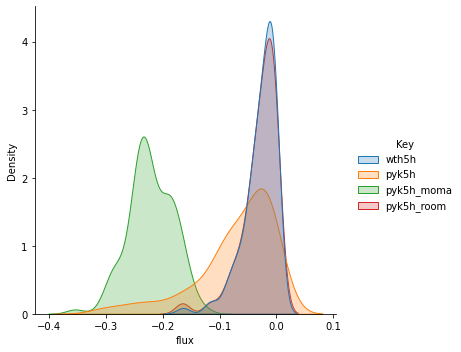

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


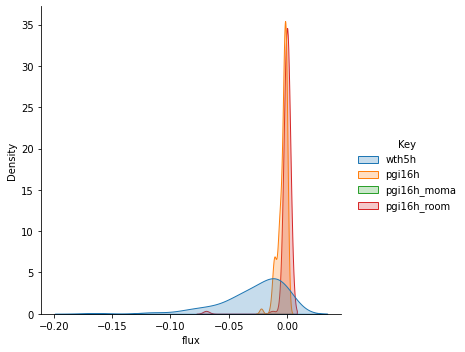

ACSERtpp


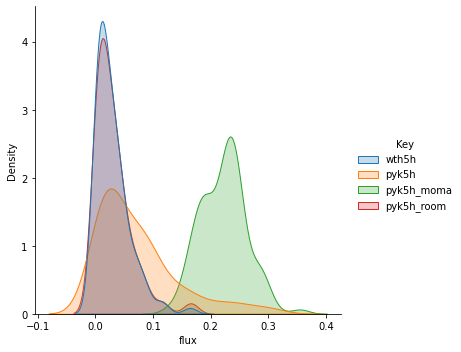

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


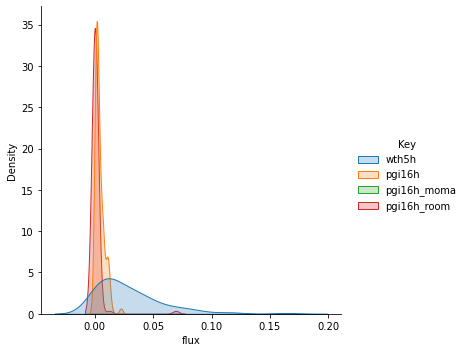

ACt2rpp


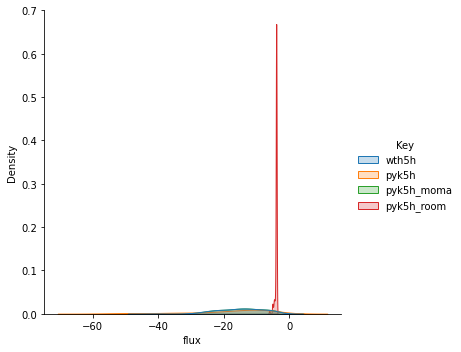

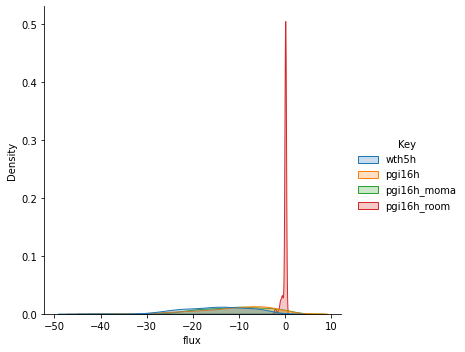

ACt4pp


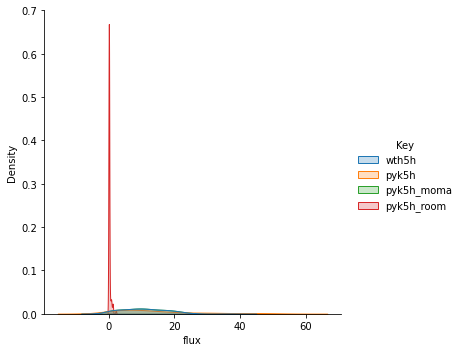

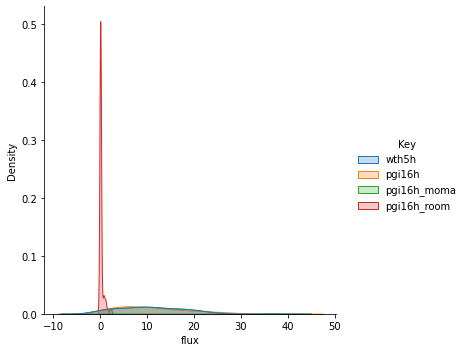

ACtex


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


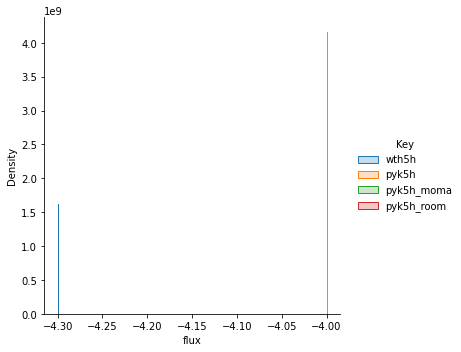

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


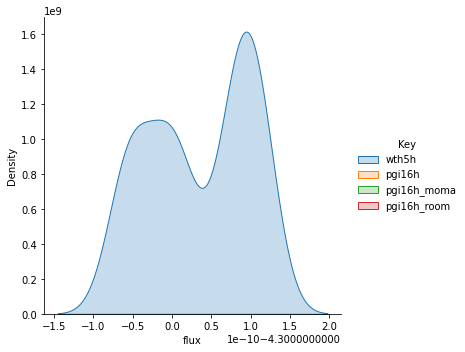

ADCL


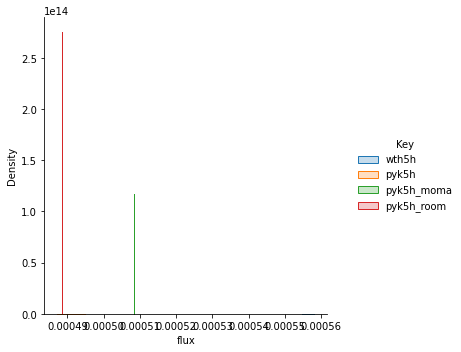

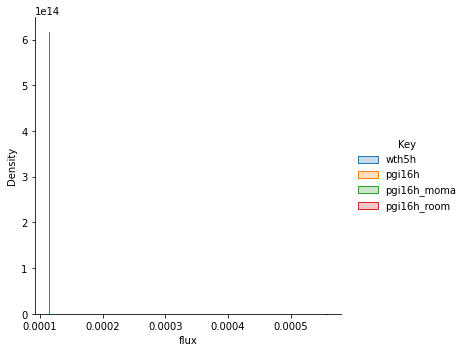

ADCS


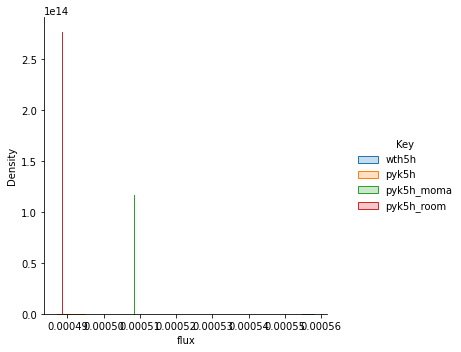

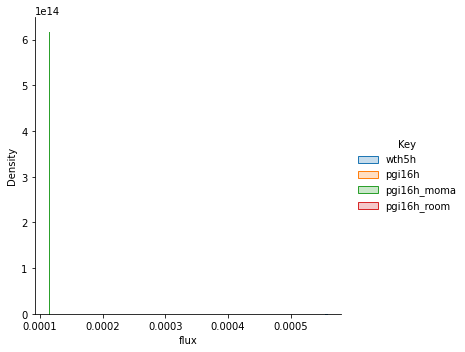

ADK1


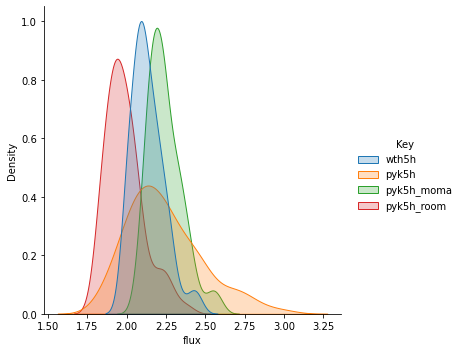

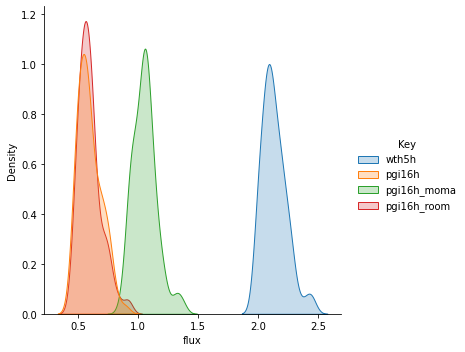

ADNK1


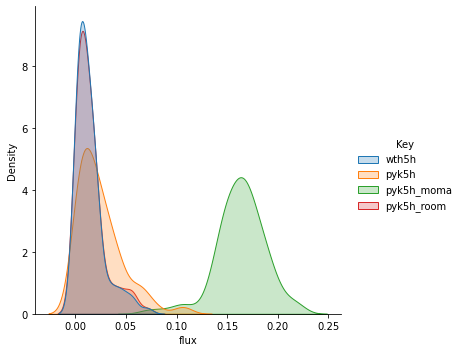

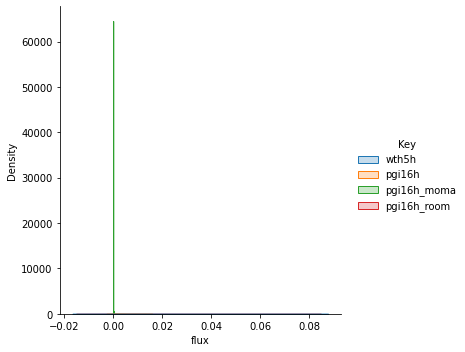

ADSK


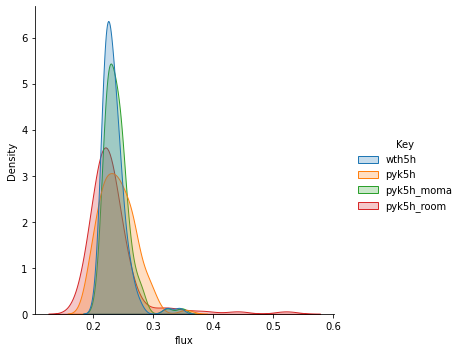

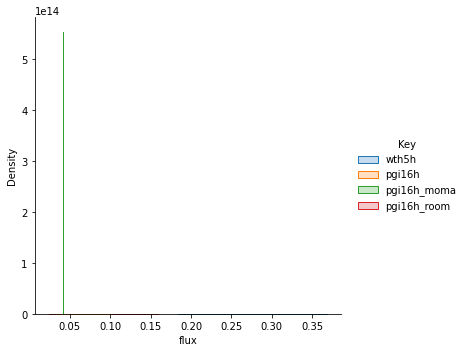

ADSL1r


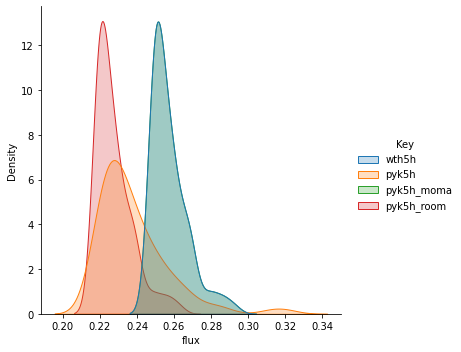

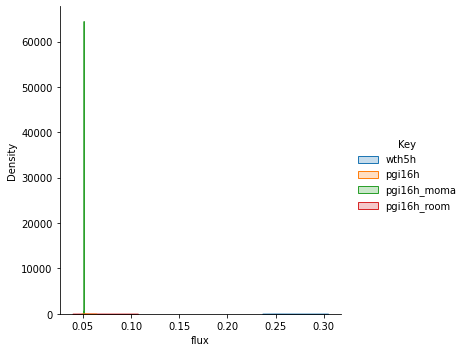

ADSL2r


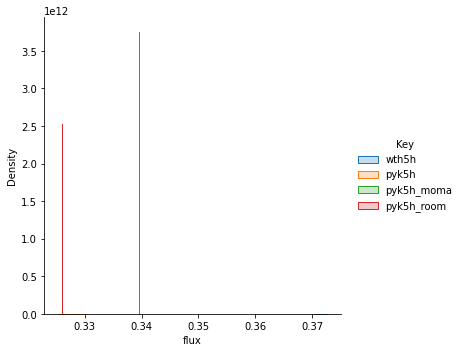

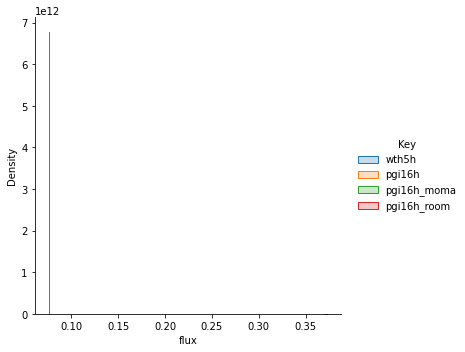

ADSS


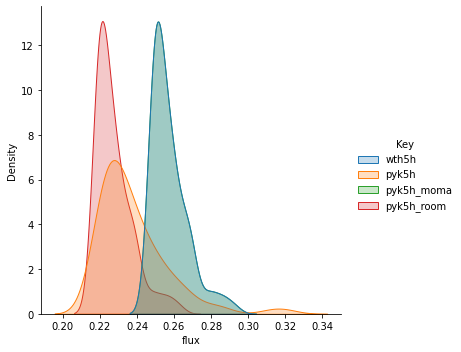

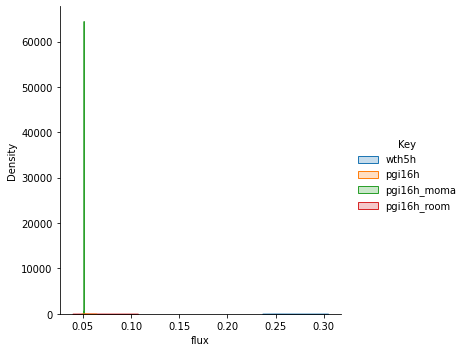

AGMHE


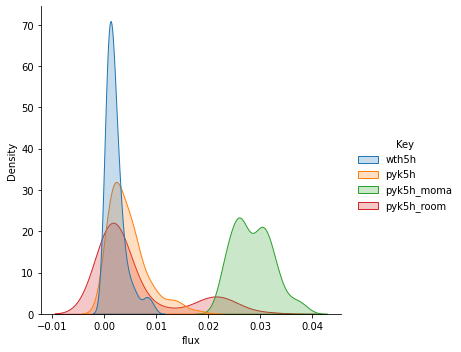

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


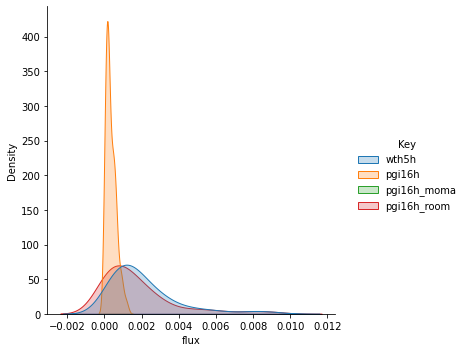

AGMT


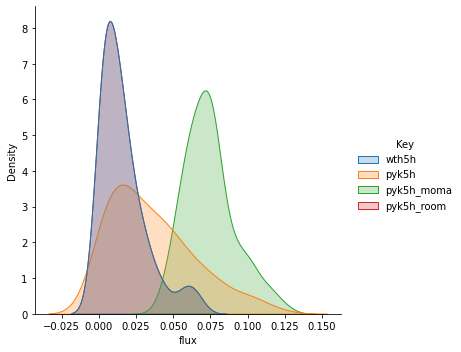

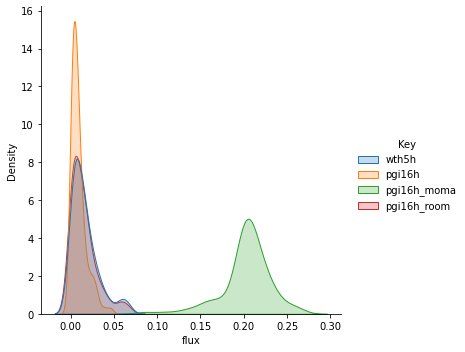

AGPAT160


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


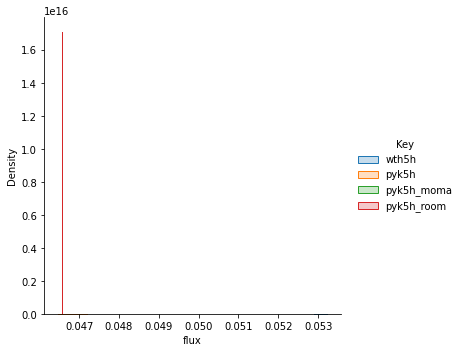

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


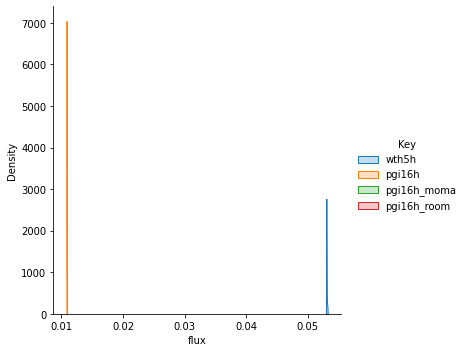

AGPAT161


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


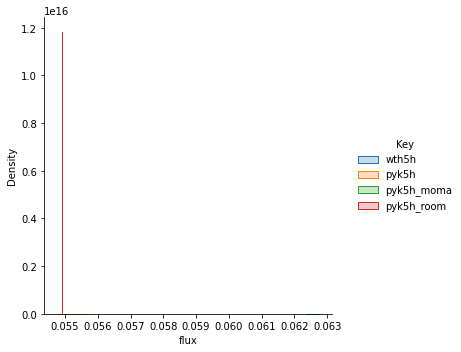

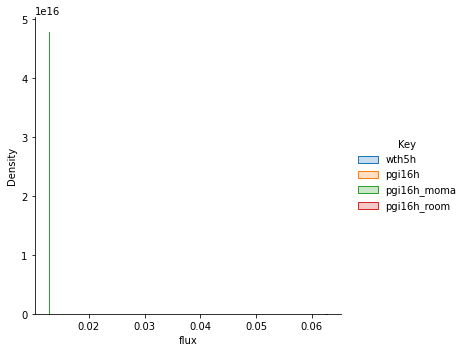

AGPR


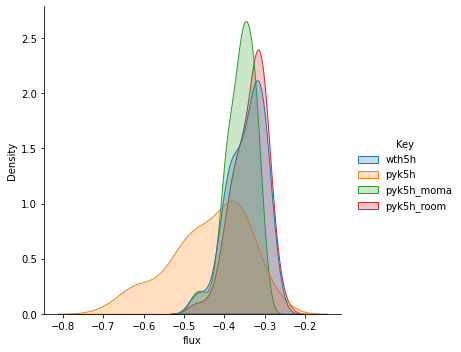

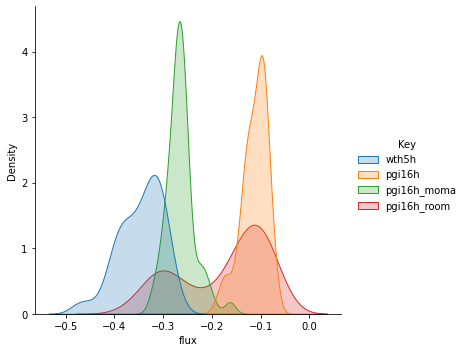

AHCYSNS


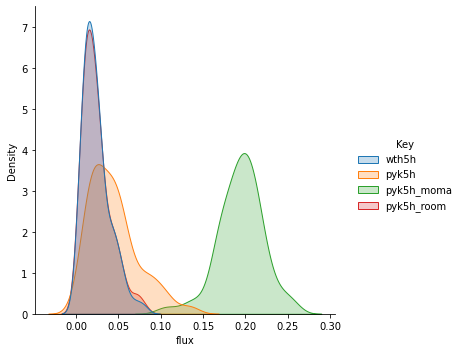

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


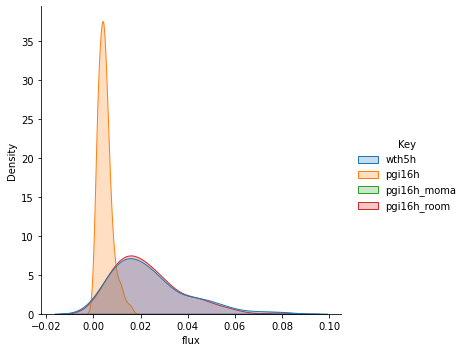

AICART


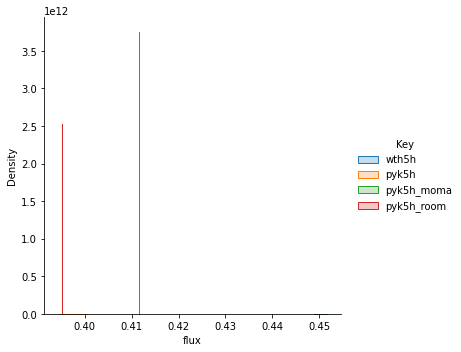

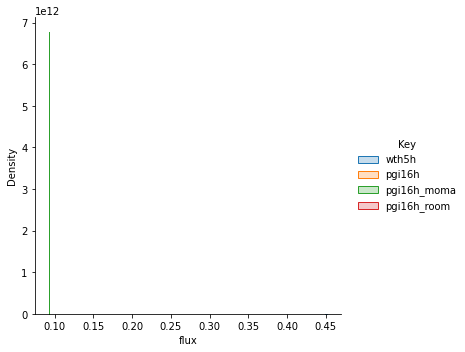

AIRC2


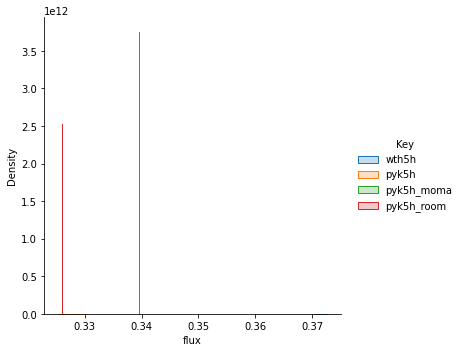

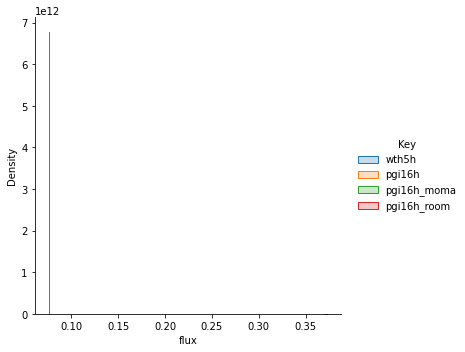

AIRC3


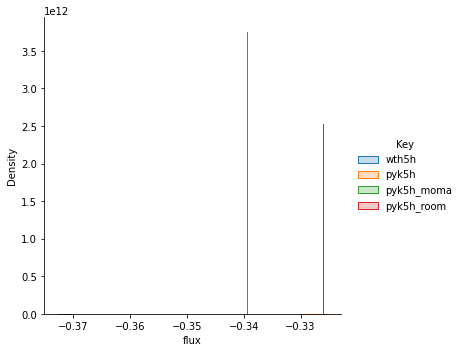

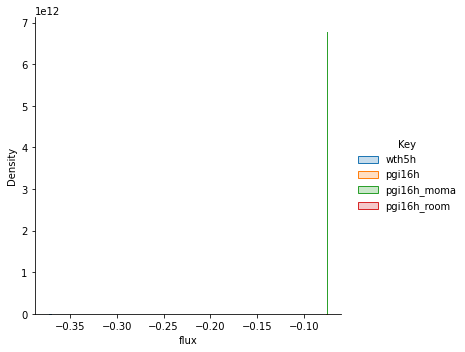

AKGDH


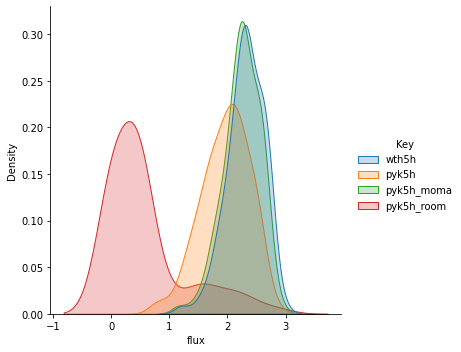

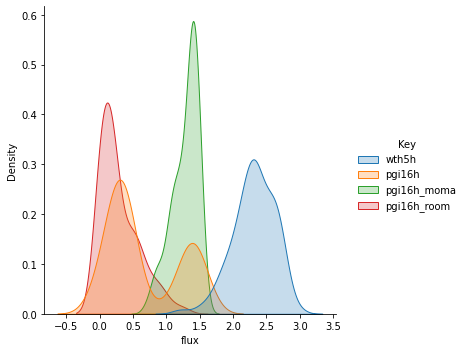

ALAALAr


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


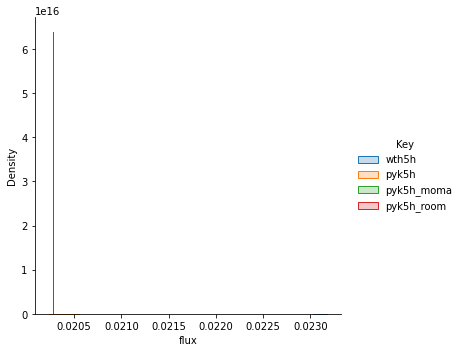

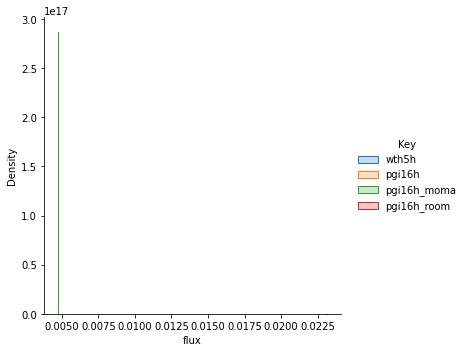

ALAR


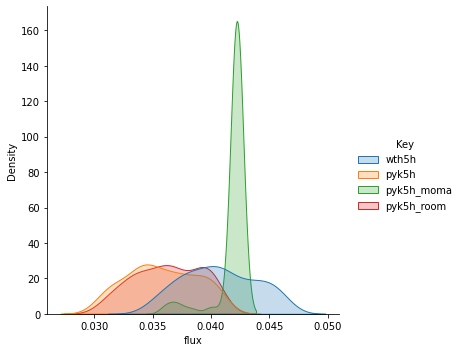

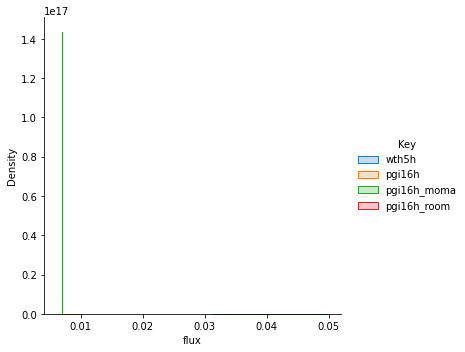

ALATA_L


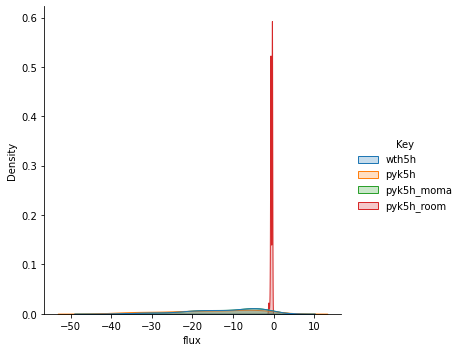

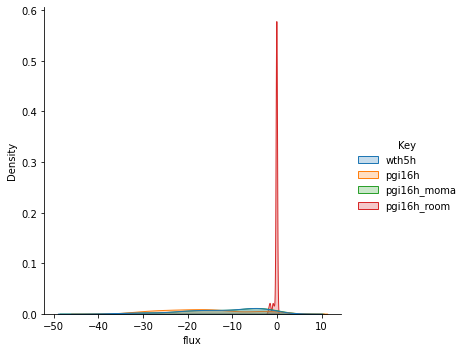

ALCD2x


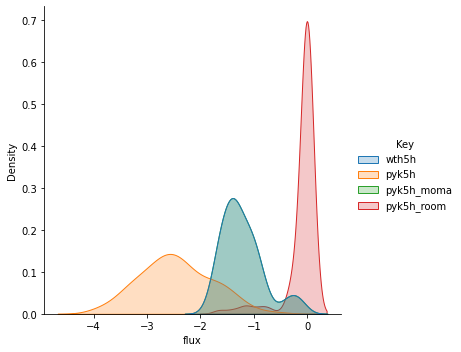

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


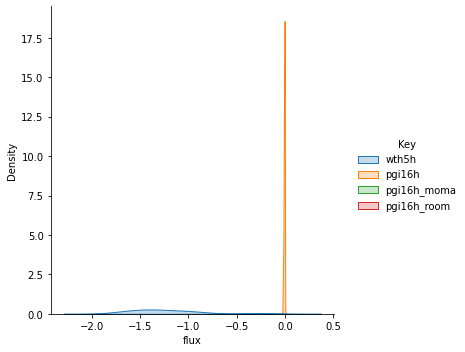

ALDD2x


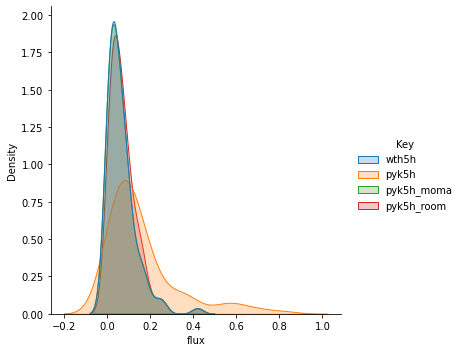

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


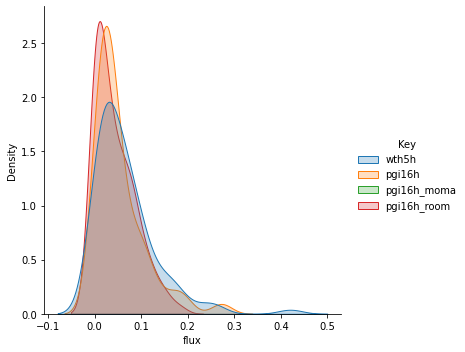

ALR2


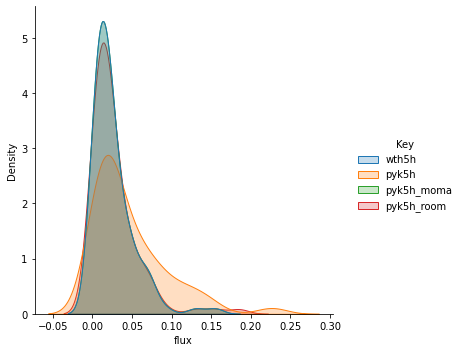

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


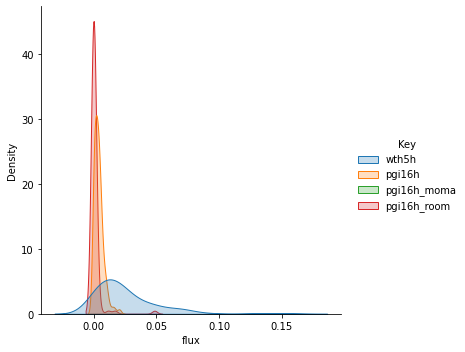

ALR4x


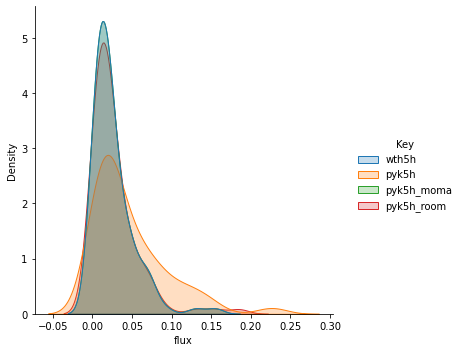

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


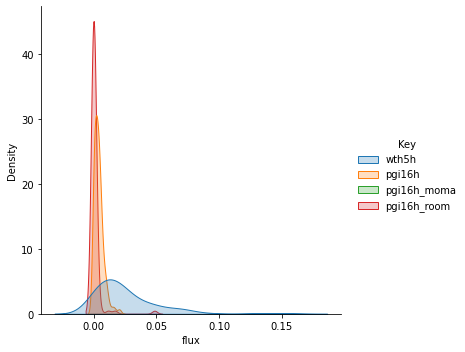

AMPMS2


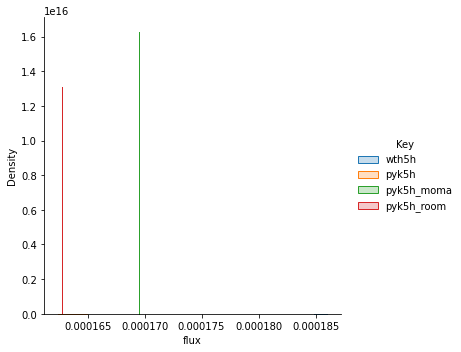

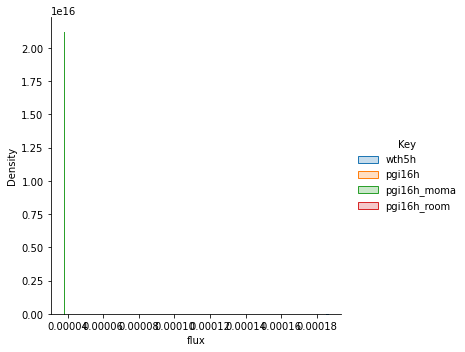

ANPRT


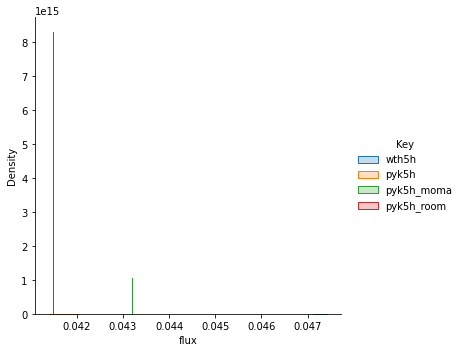

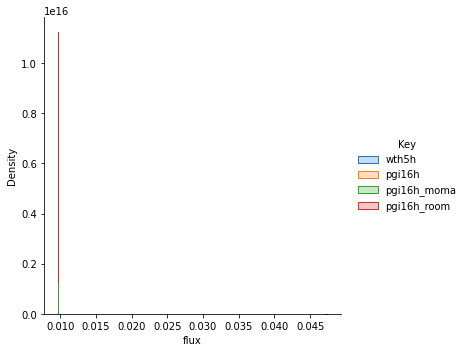

ANS


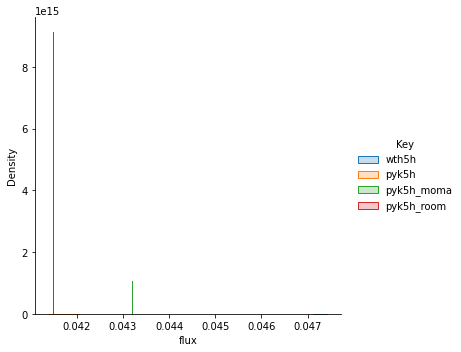

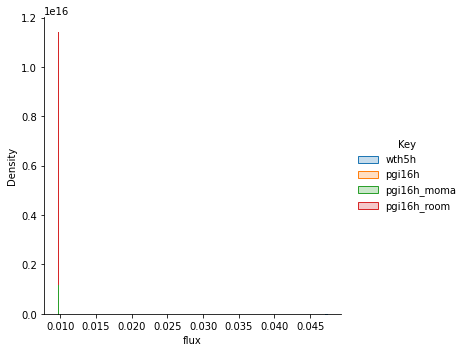

AOBUTDs


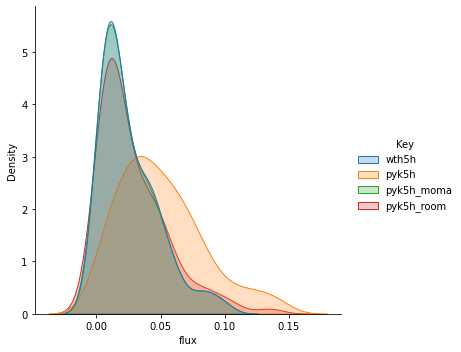

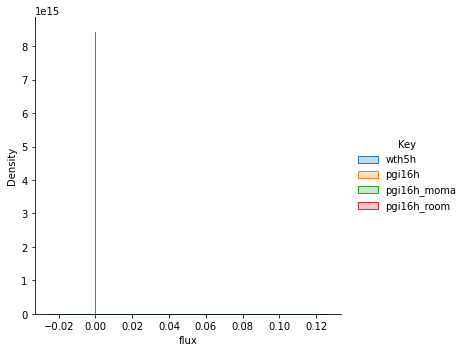

APRAUR


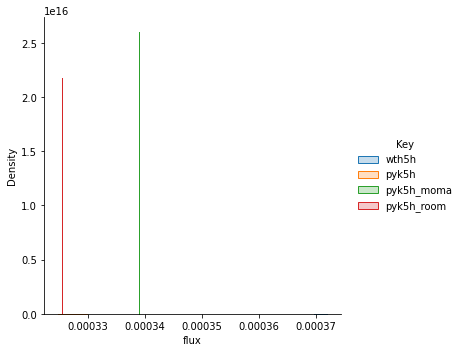

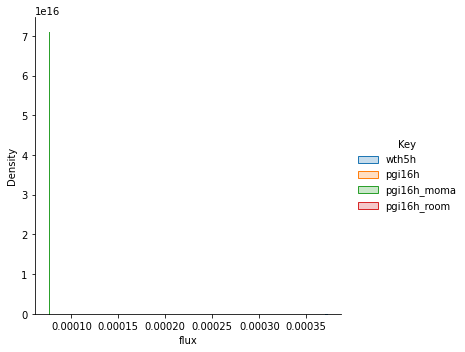

ARBTNR1


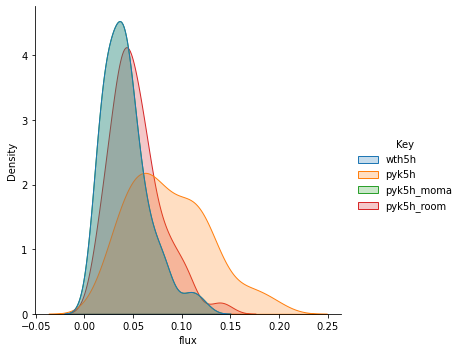

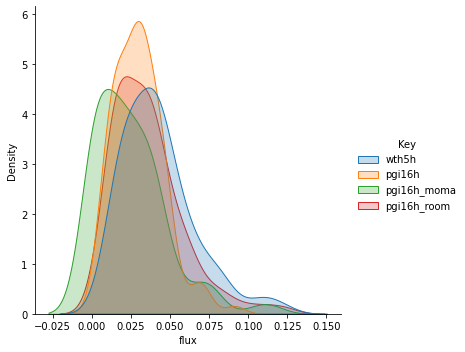

ARBTNabcpp


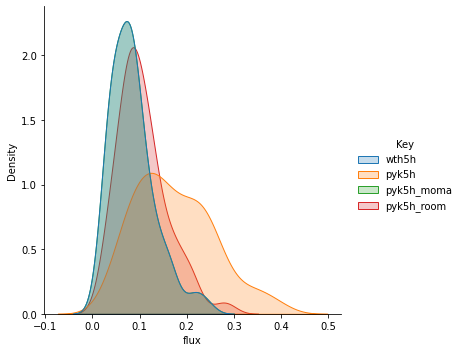

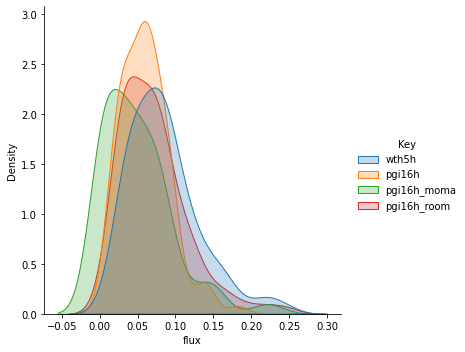

ARBTNexs


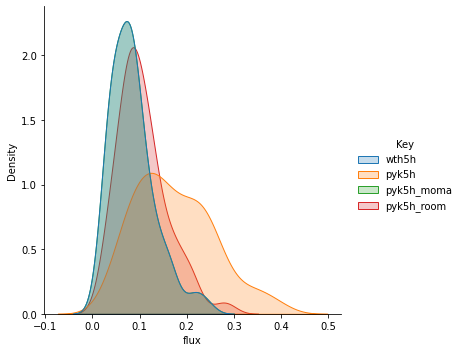

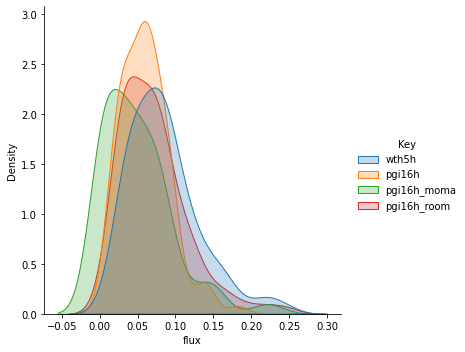

ARBTNtex


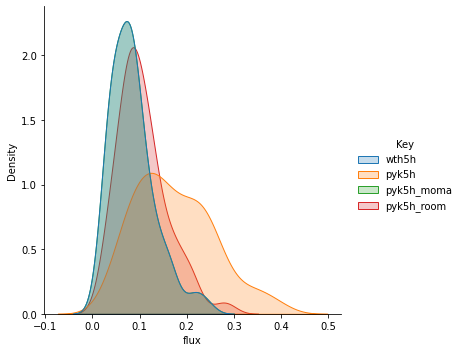

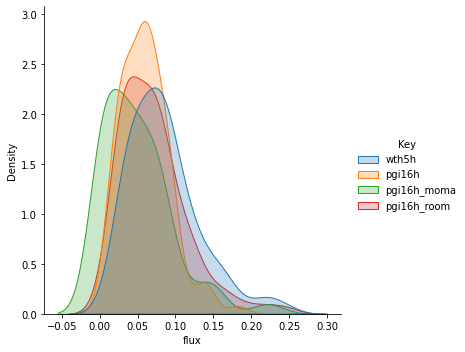

ARBTNtonex


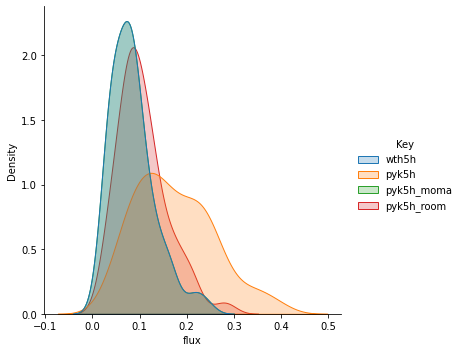

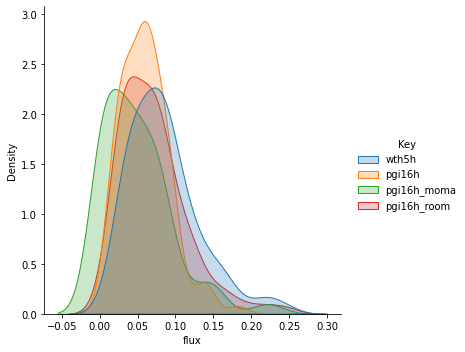

ARBTNtpp


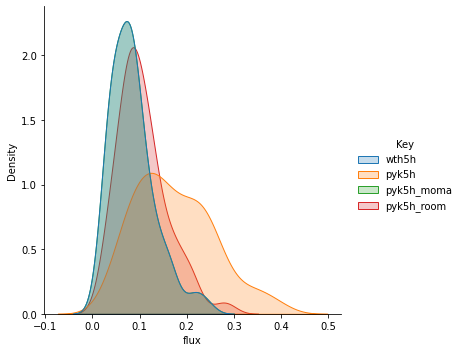

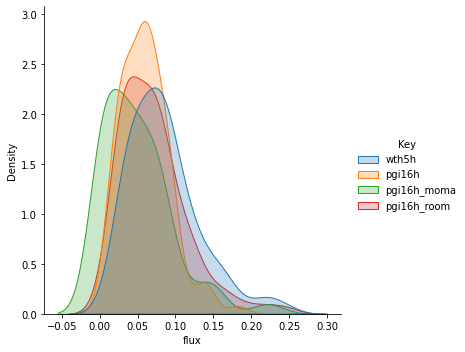

ARGDC


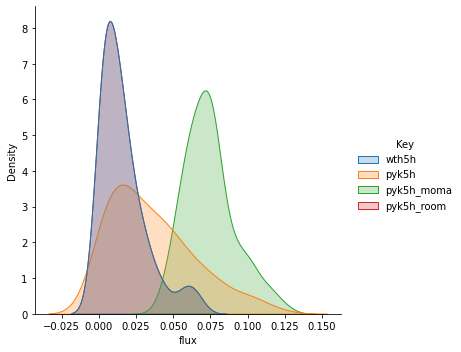

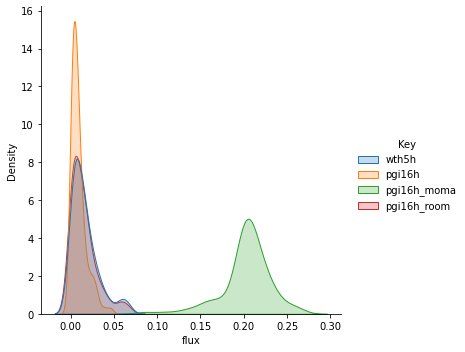

ARGORNt7pp


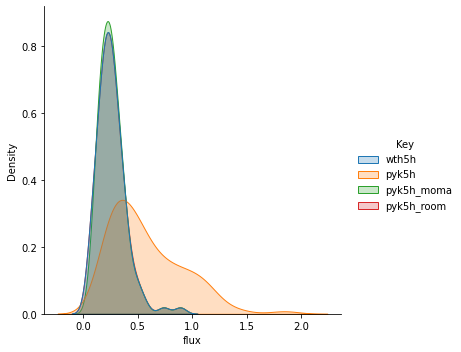

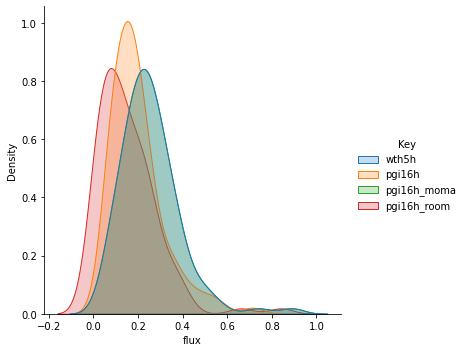

ARGSL


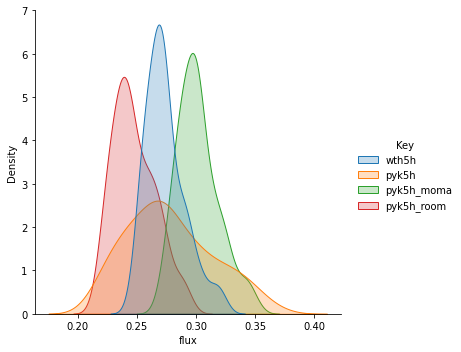

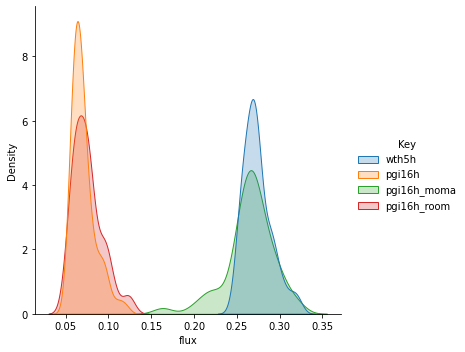

ARGSS


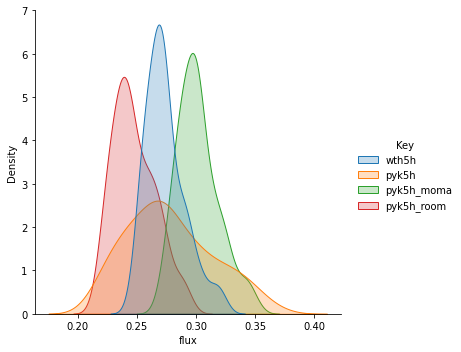

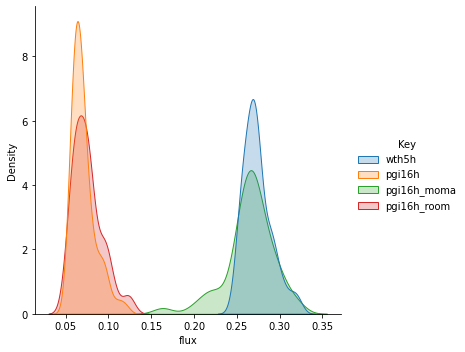

ARGabcpp


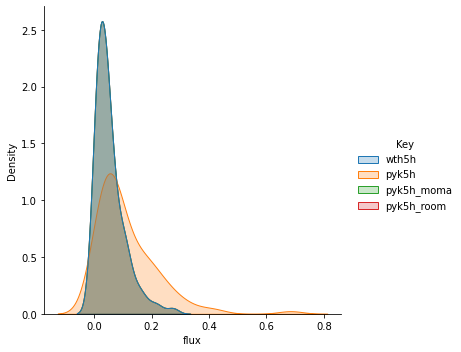

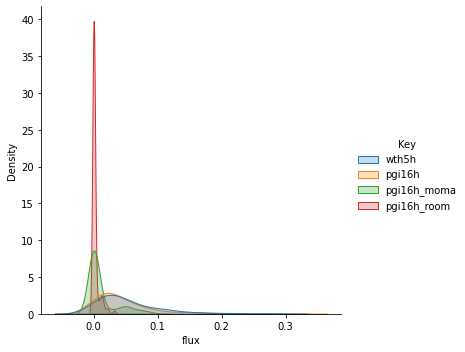

ARGt3pp


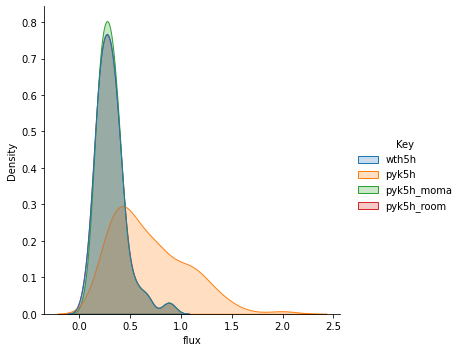

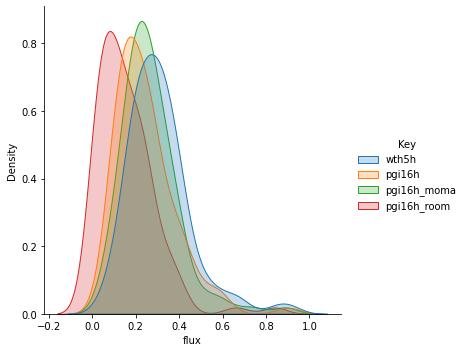

ASAD


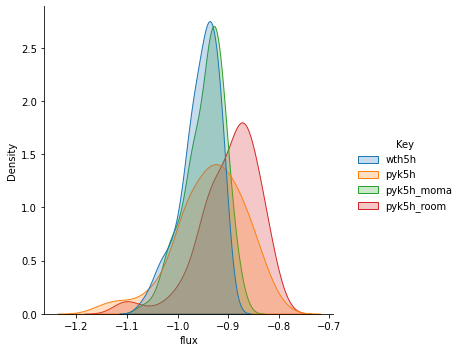

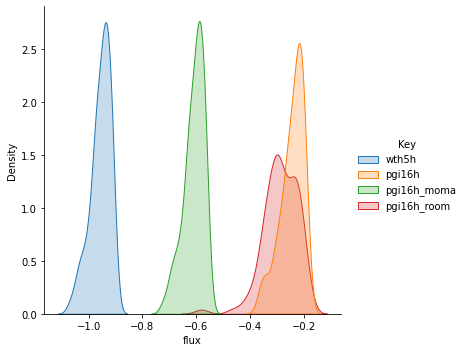

ASNN


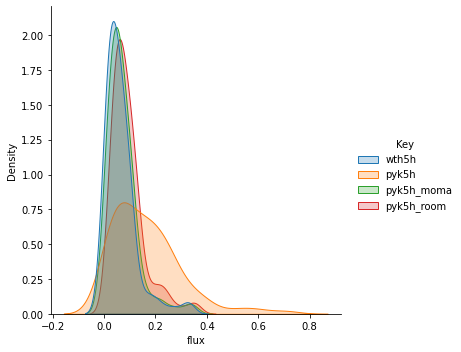

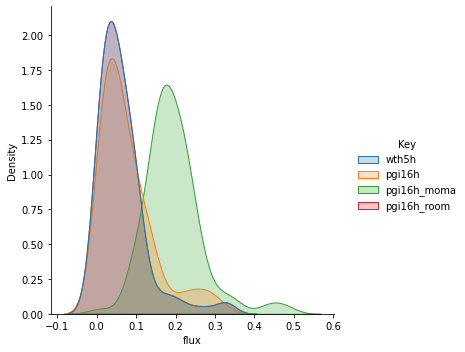

ASNS1


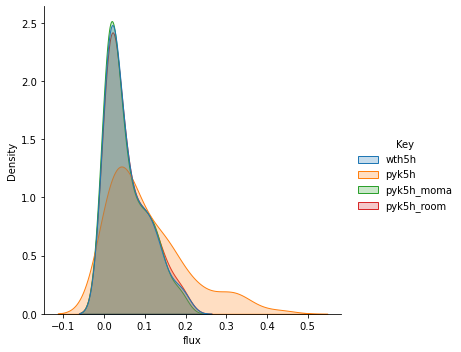

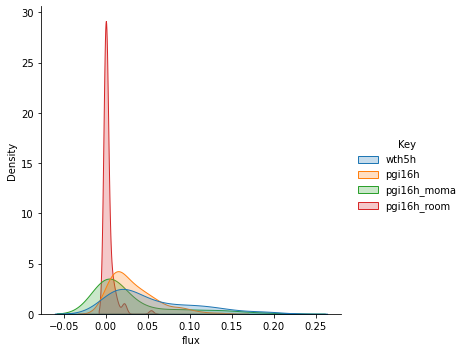

ASNS2


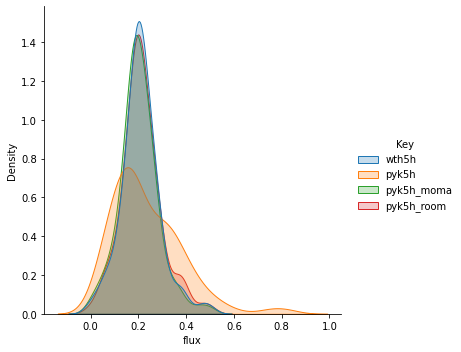

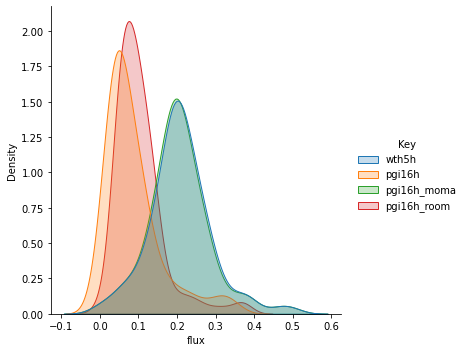

ASNabcpp


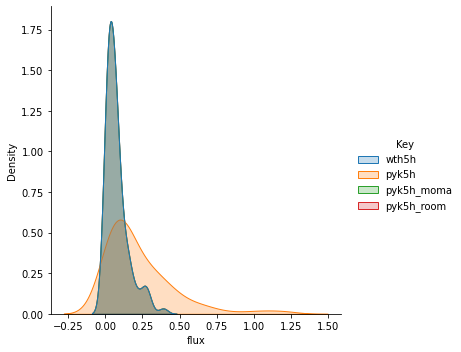

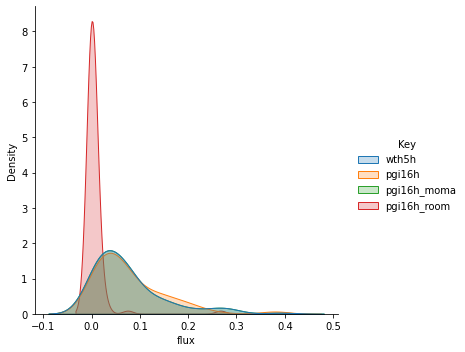

ASNt2rpp


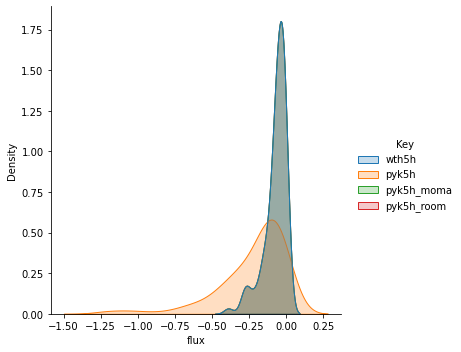

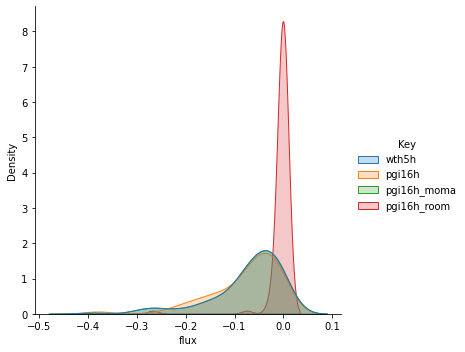

ASP1DC


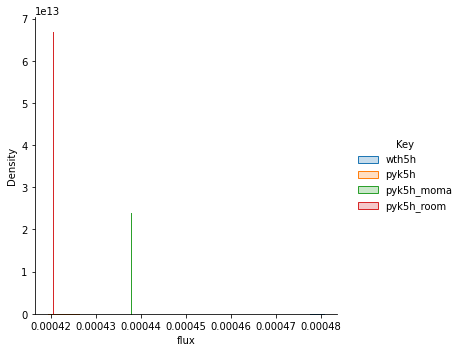

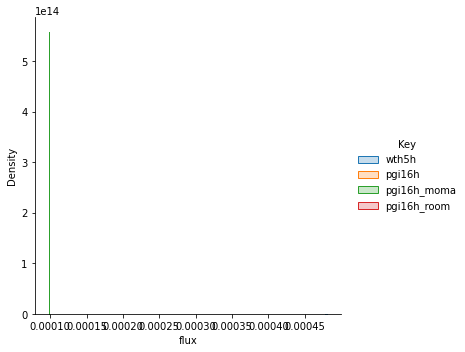

ASPCT


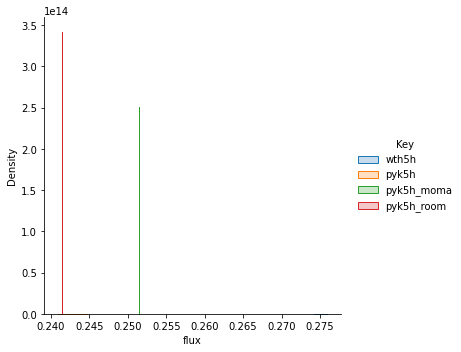

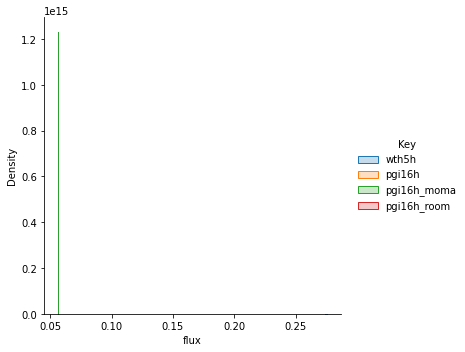

ASPK


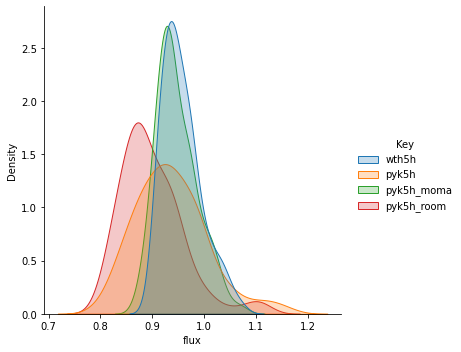

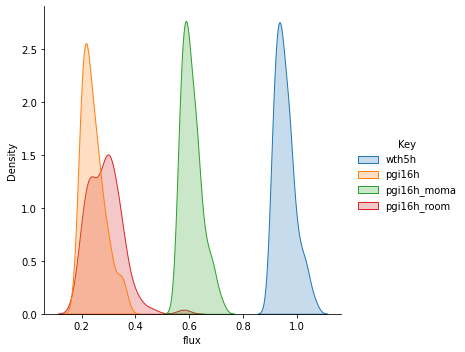

ASPO3


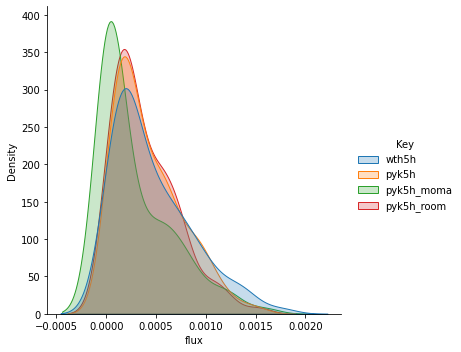

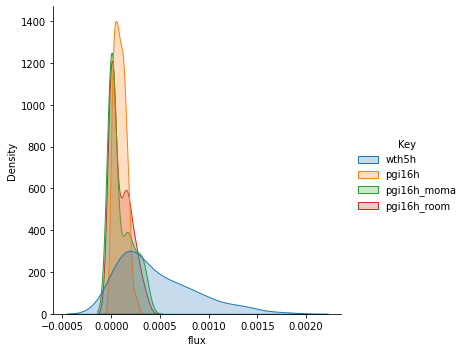

ASPO4


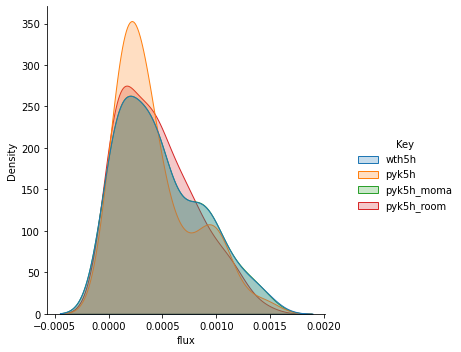

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


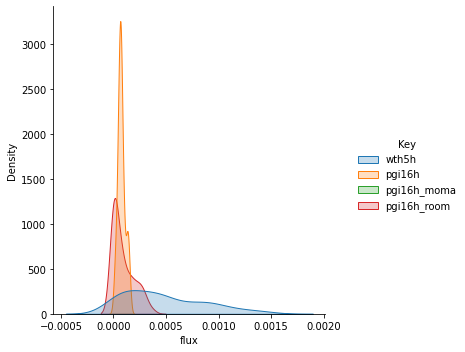

ASPO5


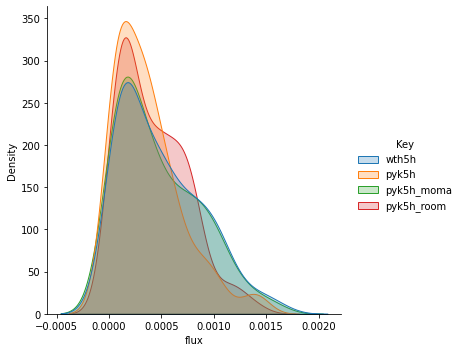

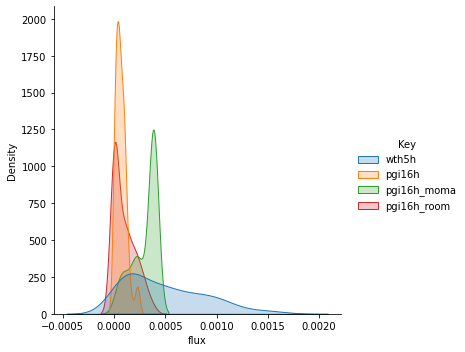

ASPO6


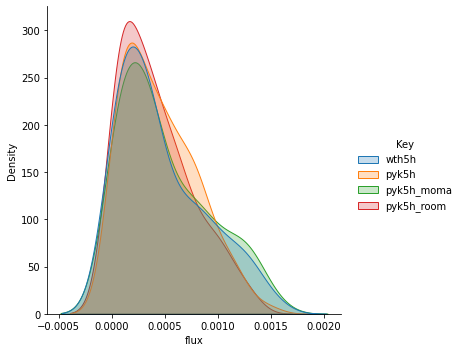

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


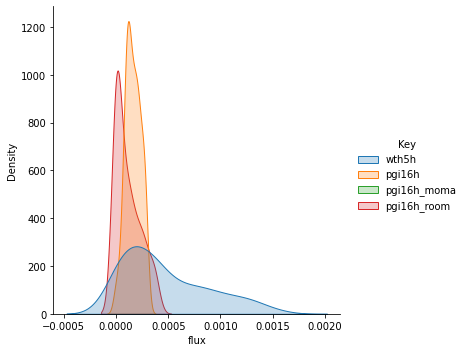

ASPT


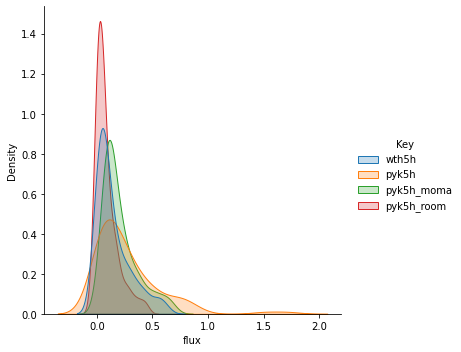

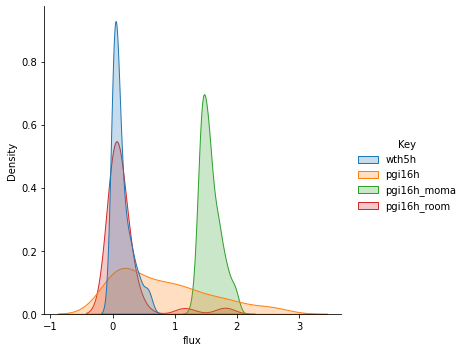

ASPTA


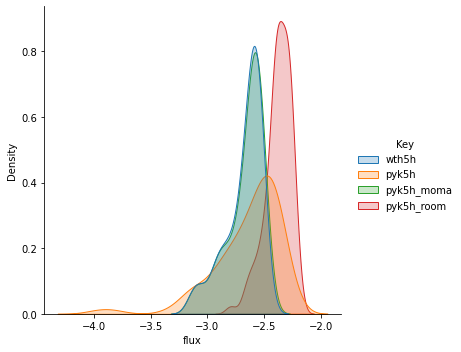

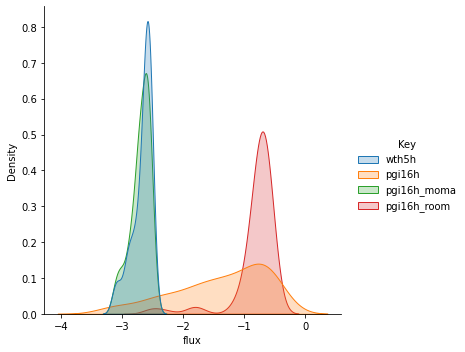

AST


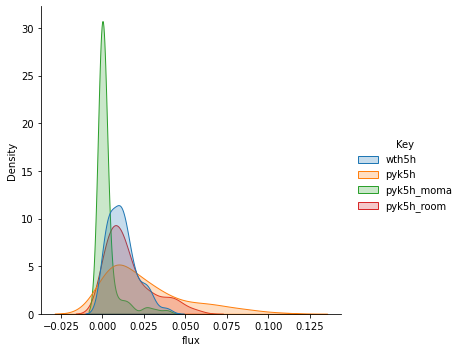

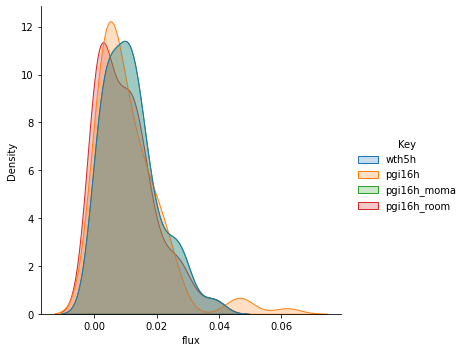

ATPM


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


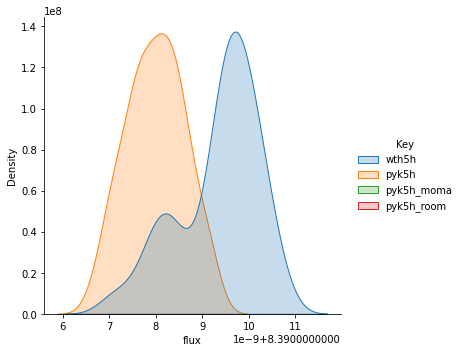

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


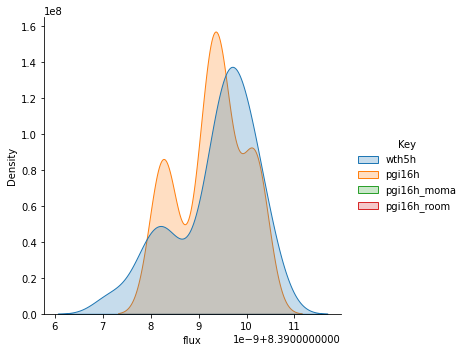

ATPPRT


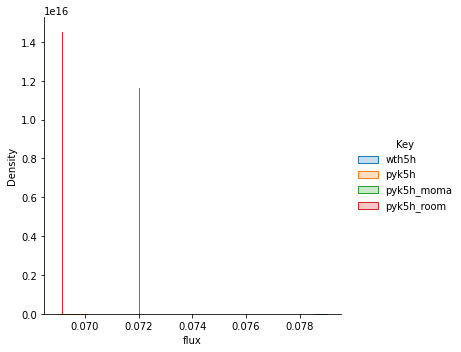

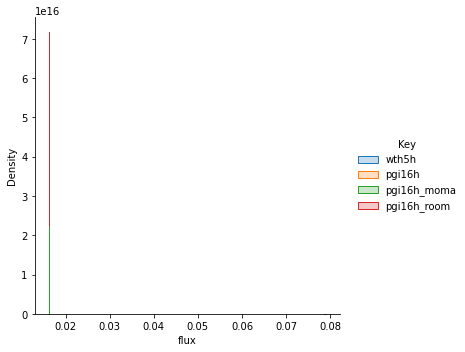

ATPS4rpp


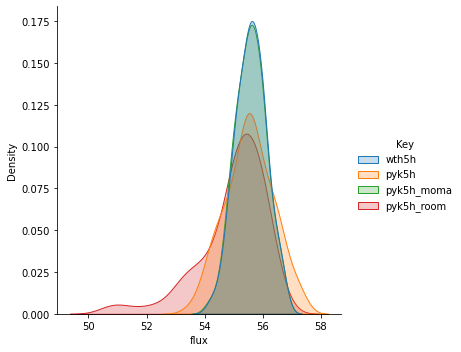

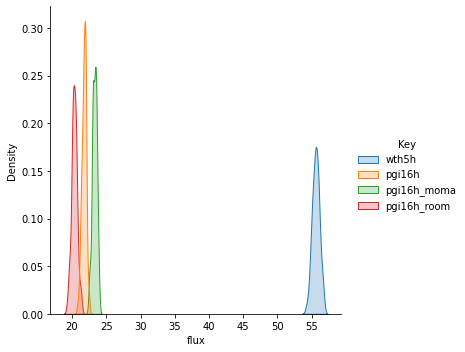

BPNT


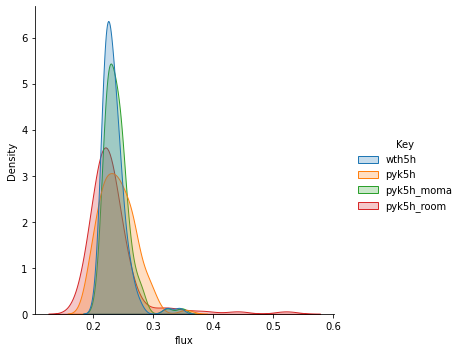

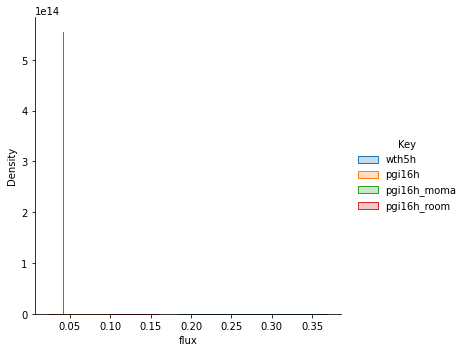

CA2t3pp


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


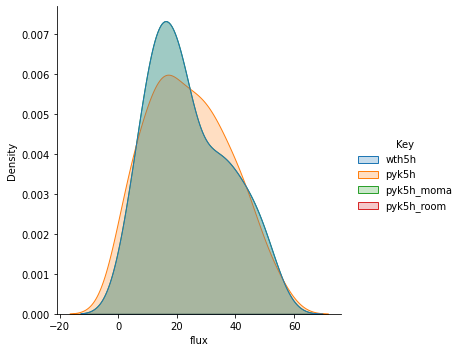

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


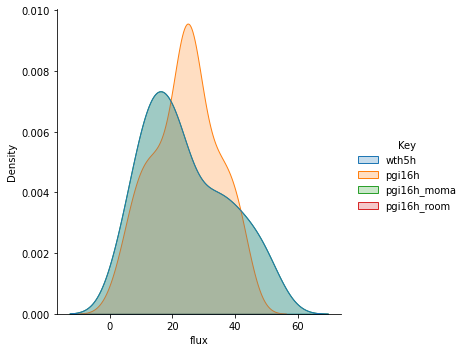

CA2tex


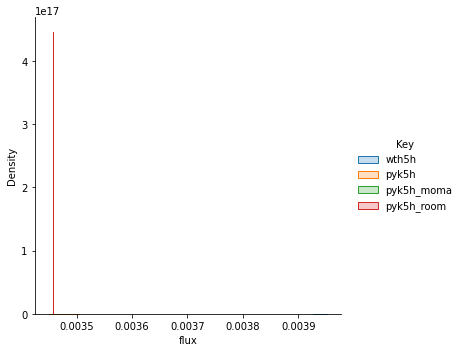

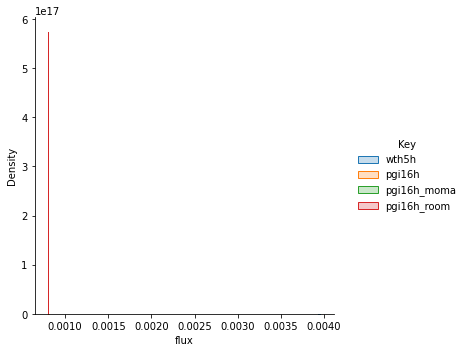

CAt6pp


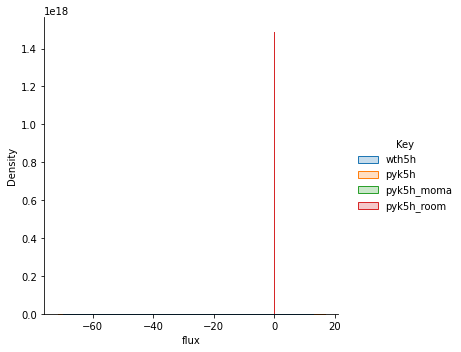

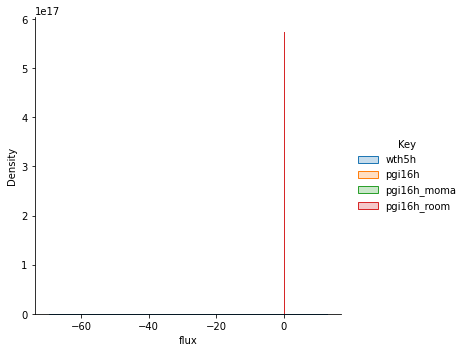

CBMKr


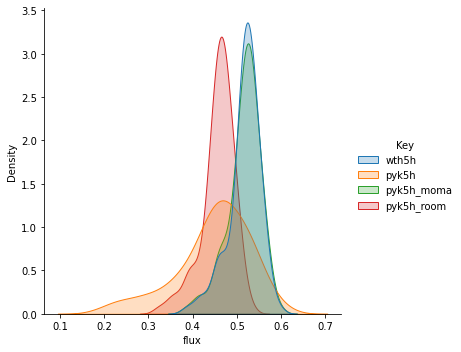

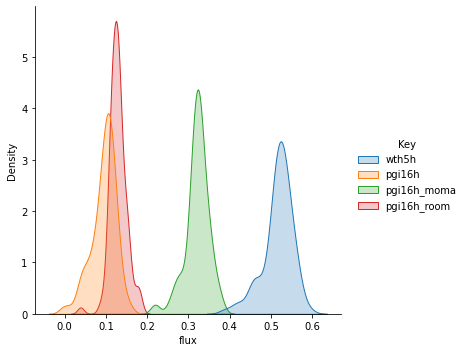

CBPS


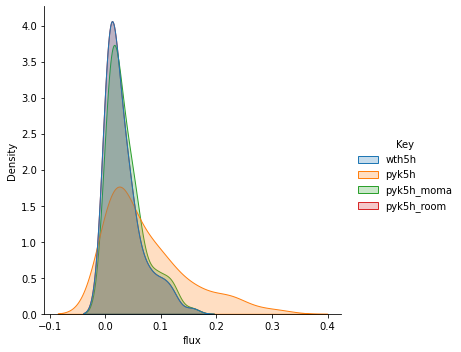

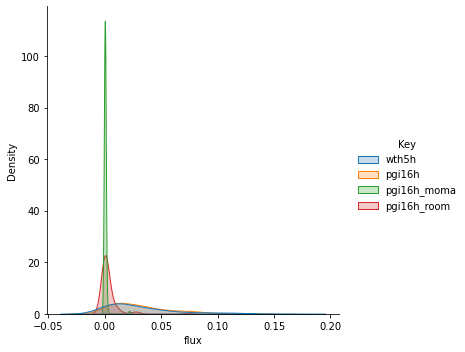

CD2t3pp


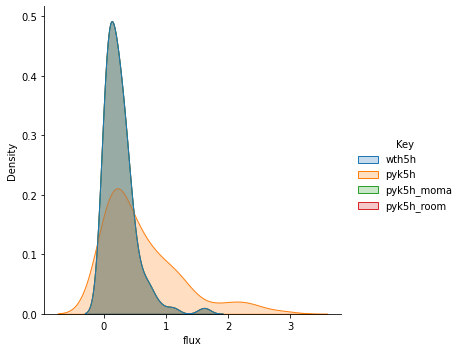

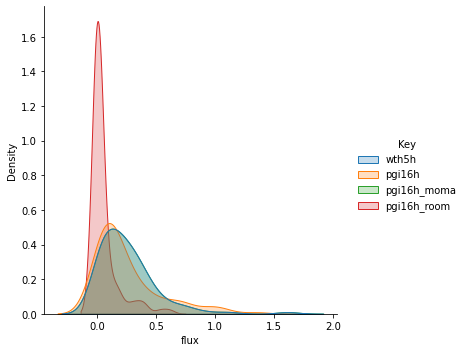

CD2tpp


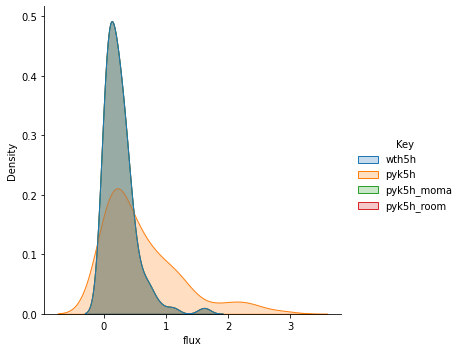

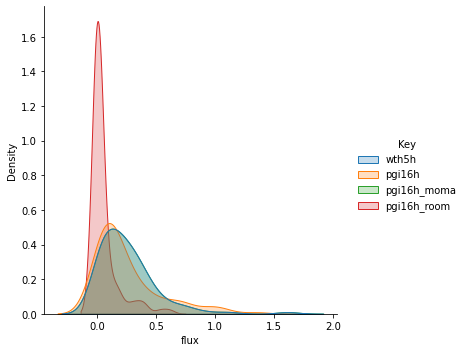

CDPMEK


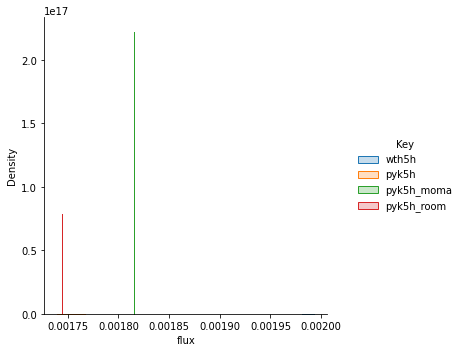

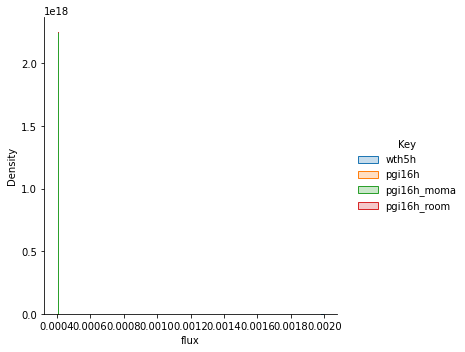

CHORM


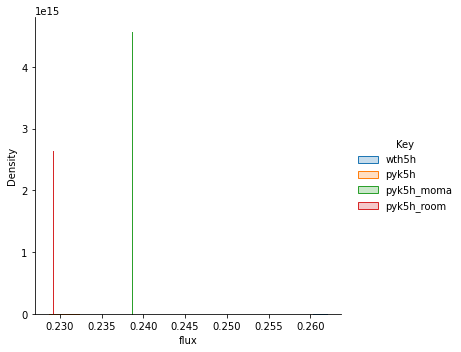

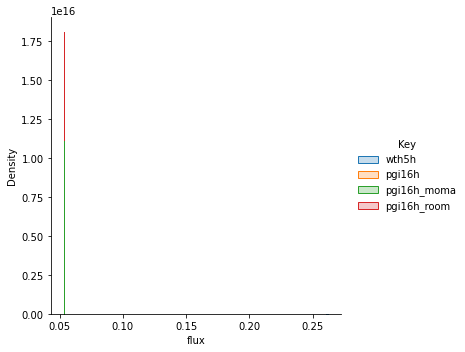

CHORS


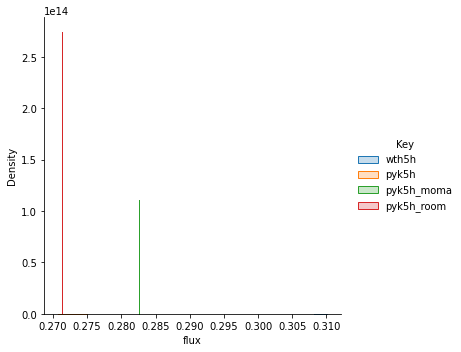

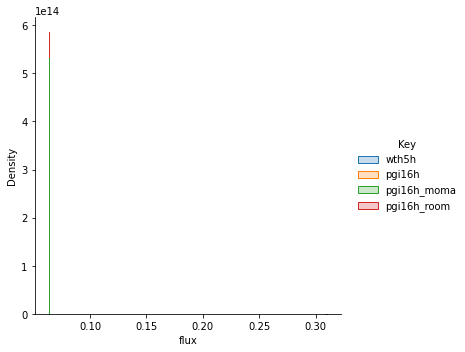

CHRPL


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


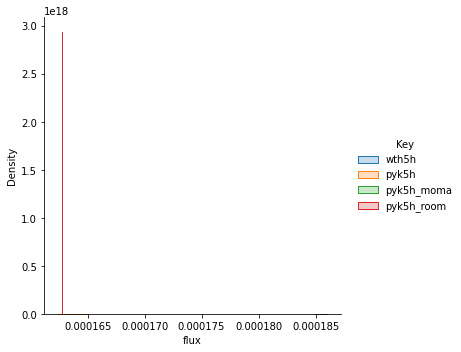

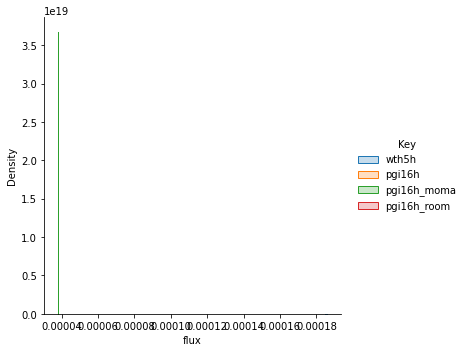

CITL


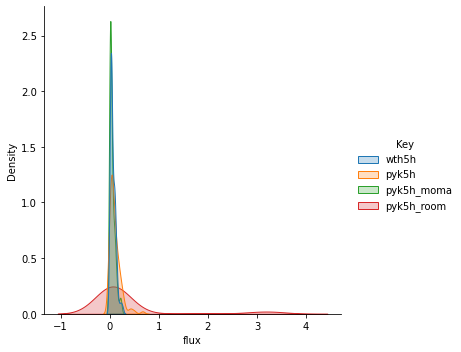

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


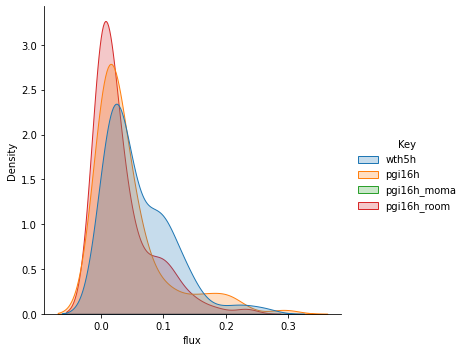

CLt3_2pp


LinAlgError: singular matrix

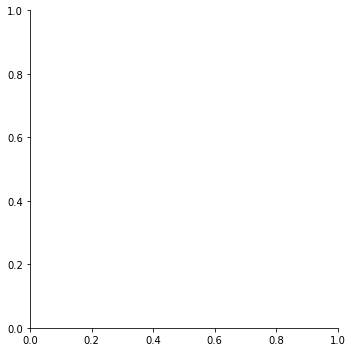

In [29]:
for reaction in [r.id for r in model.reactions]:
    print(reaction)
    
    samplewt5h = pd.DataFrame([('wth5h', x) for x in samples_wt5h[reaction]], columns = ['Key', 'flux'])
    samplepyk5h = pd.DataFrame([('pyk5h', x) for x in samples_pyk5h[reaction]], columns = ['Key', 'flux'])
    samplemomapyk5h = pd.DataFrame([('pyk5h_moma', x) for x in momaPykPrediction[reaction]], columns = ['Key', 'flux'])
    sampleroompyk5h = pd.DataFrame([('pyk5h_room', x) for x in roomPykPrediction[reaction]], columns = ['Key', 'flux'])
    mergedSamples = pd.concat([samplewt5h, samplepyk5h, samplemomapyk5h, sampleroompyk5h], ignore_index=True)
    sns.displot(mergedSamples, x="flux", hue="Key", kind="kde", fill=True)
    plt.show()
    
    sample_pgi16h = pd.DataFrame([('pgi16h', x) for x in samples_pgi16h[reaction]], columns = ['Key', 'flux'])
    samplemoma_pgi16h = pd.DataFrame([('pgi16h_moma', x) for x in momaPgiPrediction[reaction]], columns = ['Key', 'flux'])
    sampleroom_pgi16h = pd.DataFrame([('pgi16h_room', x) for x in roomPgiPrediction[reaction]], columns = ['Key', 'flux'])
    mergedSamplespgi16h = pd.concat([samplewt5h, sample_pgi16h, samplemoma_pgi16h, sampleroom_pgi16h], ignore_index=True)
    sns.displot(mergedSamplespgi16h, x="flux", hue="Key", kind="kde", fill=True)
    plt.show()

In [30]:
reaction = 'CBMKr'
samplewt5h = pd.DataFrame([('wth5h', x) for x in samples_wt5h[reaction]], columns = ['Key', 'flux'])
samplepyk5h = pd.DataFrame([('pyk5h', x) for x in samples_pyk5h[reaction]], columns = ['Key', 'flux'])
samplemomapyk5h = pd.DataFrame([('pyk5h_moma', x) for x in momaPykPrediction[reaction]], columns = ['Key', 'flux'])
sampleroompyk5h = pd.DataFrame([('pyk5h_room', x) for x in roomPykPrediction[reaction]], columns = ['Key', 'flux'])
mergedSamples = pd.concat([samplewt5h, samplepyk5h, samplemomapyk5h, sampleroompyk5h], ignore_index=True)

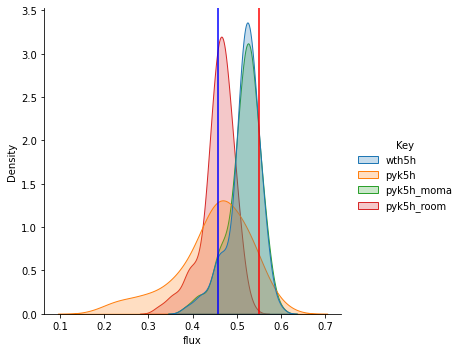

In [31]:
# depict visualization
ax = sns.displot(mergedSamples, x="flux", hue="Key", kind="kde", fill=True)
# plt.xlim(9,13)
plt.axvline(fbamoma_pyk5h[reaction], color='red')
plt.axvline(fbaroom_pyk5h[reaction], color='blue')
# plt.show()
plt.savefig('outputdata/pyk5h_predict2.svg')

In [32]:
sample_pgi16h = pd.DataFrame([('pgi16h', x) for x in samples_pgi16h[reaction]], columns = ['Key', 'flux'])
samplemoma_pgi16h = pd.DataFrame([('pgi16h_moma', x) for x in momaPgiPrediction[reaction]], columns = ['Key', 'flux'])
sampleroom_pgi16h = pd.DataFrame([('pgi16h_room', x) for x in roomPgiPrediction[reaction]], columns = ['Key', 'flux'])
mergedSamplespgi16h = pd.concat([samplewt5h, sample_pgi16h, samplemoma_pgi16h, sampleroom_pgi16h], ignore_index=True)

In [49]:
print(sns.color_palette("colorblind").as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [56]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

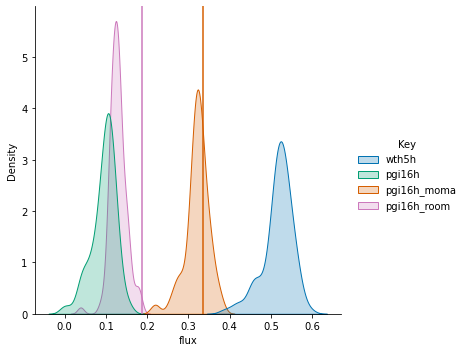

In [70]:
# depict visualization
palette = ['#0173B2',
 # '#DE8F05',
 '#029E73',
 '#D55E00',
 '#CC78BC',
 # '#CA9161',
 # '#FBAFE4',
 # '#949494',
 # '#ECE133',
 # '#56B4E9'
          ]

ax = sns.displot(mergedSamplespgi16h, x="flux", hue="Key", kind="kde", fill=True, palette=palette)
# plt.xlim(3.0, 4.0)
# plt.ylim(0.0, 20.0)
plt.axvline(fbamoma_pgi16h[reaction], color='#D55E00')
plt.axvline(fbaroom_pgi16h[reaction]+0.08, color='#CC78BC')
plt.savefig('outputdata/pgi16h_predict.svg')